In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_10850/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


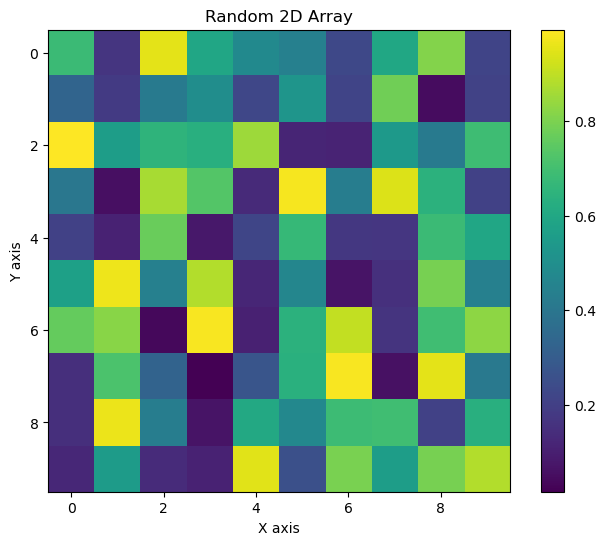

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += val_loss_temp.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board ########################
# decay = 0.4 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# const2 = True # trace 할거면 True, 안할거면 False

# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

# if const2 == True:
#     const2 = decay
# else:
#     const2 = 0.0

# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "2",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 64, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'DVS_GESTURE_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',512],
#                 cfg = ['M','M',200,200],
#                 # cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.005, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 5, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = False, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
    'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
    'parameters': 
    {
        "learning_rate": {"values": [0.009]},
        "BATCH": {"values": [64]},
        "decay": {"values": [0.5]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [10]},
        "epoch_num": {"values": [15]},
        "dvs_duration": {"values": [100_000]},
        "dvs_clipping": {"values": [1,2,3,4,5,6]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [False]},
        "surrogate": {"values": ['rectangle', 'sigmoid', 'hard_sigmoid']},
        "DFA_on": {"values": [False]},
        "OTTT_input_trace_on": {"values": [False]},
        "cfg": {"values": [['M','M',200,200]]},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    DFA_on  =  wandb.config.DFA_on
    OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
    cfg  =  wandb.config.cfg

    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "1",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',200,200],
                # cfg = [200,200],
                cfg = cfg,
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: sauojyu0
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/sauojyu0


wandb: Agent Starting Run: 9qgqasw4 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:24.53%, lr=['0.009'], iter_loss:19.82001304626465, tr:20.71%, val:25.00%, val_best:25.00%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.498374223709106 seconds

EPOCH 1



1-16/17 iter:37.74%, lr=['0.008901664203302125'], iter_loss:14.284132957458496, tr:35.38%, val:31.06%, val_best:31.06%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.50761651992798 seconds

EPOCH 2



2-16/17 iter:30.19%, lr=['0.008610954559391704'], iter_loss:17.68311309814453, tr:41.04%, val:39.39%, val_best:39.39%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.73524618148804 seconds

EPOCH 3



3-16/17 iter:37.74%, lr=['0.008140576474687264'], iter_loss:15.639205932617188, tr:42.34%, val:38.64%, val_best:39.39%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.75985074043274 seconds

EPOCH 4



4-16/17 iter:39.62%, lr=['0.007511087728614862'], iter_loss:14.518363952636719, tr:46.43%, val:39.02%, val_best:39.39%: 100%|██████████| 17/17 [00:37<00:00,  2.21s/it]

epoch_time: 37.67178273200989 seconds

EPOCH 5



5-16/17 iter:47.17%, lr=['0.00675'], iter_loss:13.314789772033691, tr:46.43%, val:34.47%, val_best:39.39%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 40.03904438018799 seconds

EPOCH 6



6-16/17 iter:50.94%, lr=['0.005890576474687264'], iter_loss:14.13630485534668, tr:48.19%, val:40.91%, val_best:40.91%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.86423349380493 seconds

EPOCH 7



7-16/17 iter:52.83%, lr=['0.0049703780847044415'], iter_loss:14.166755676269531, tr:48.84%, val:38.26%, val_best:40.91%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.81300377845764 seconds

EPOCH 8



8-16/17 iter:33.96%, lr=['0.00402962191529556'], iter_loss:15.423955917358398, tr:50.05%, val:44.32%, val_best:44.32%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.95120978355408 seconds

EPOCH 9



9-16/17 iter:56.60%, lr=['0.0031094235253127374'], iter_loss:12.413875579833984, tr:54.13%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.872629165649414 seconds

EPOCH 10



10-16/17 iter:50.94%, lr=['0.002250000000000001'], iter_loss:11.862483024597168, tr:55.62%, val:44.32%, val_best:47.35%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.64831018447876 seconds

EPOCH 11



11-16/17 iter:69.81%, lr=['0.0014889122713851394'], iter_loss:11.051765441894531, tr:56.55%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]

epoch_time: 37.58437991142273 seconds

EPOCH 12



12-16/17 iter:66.04%, lr=['0.0008594235253127369'], iter_loss:11.335650444030762, tr:60.45%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 42.9272825717926 seconds

EPOCH 13



13-16/17 iter:71.70%, lr=['0.0003890454406082956'], iter_loss:11.104222297668457, tr:62.02%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.19092607498169 seconds

EPOCH 14



14-16/17 iter:71.70%, lr=['9.83357966978744e-05'], iter_loss:11.615499496459961, tr:64.90%, val:53.79%, val_best:56.06%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]


epoch_time: 41.39956498146057 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▃▂▃▃▄▂▄▅▃▅▅▅▅▇▄▄▆▄▆▅▆▅▆▆▅▆▆▇▅▅▅▆▇▇█▆█▇█
summary_val_acc,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
tr_acc,▁▁▁▃▃▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
val_acc_best,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
val_acc_now,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
epoch,14
iter_acc,0.71698
tr_acc,0.64903
val_acc_best,0.56061
val_acc_now,0.53788


wandb: Agent Starting Run: zq1drkut with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:13.21%, lr=['0.009'], iter_loss:22.32411766052246, tr:12.72%, val:18.56%, val_best:18.56%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.223851919174194 seconds

EPOCH 1



1-16/17 iter:67.92%, lr=['0.008901664203302125'], iter_loss:12.165528297424316, tr:42.99%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.745351791381836 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:14.639570236206055, tr:55.52%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.941417932510376 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.008140576474687264'], iter_loss:10.609504699707031, tr:60.45%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.4266676902771 seconds

EPOCH 4



4-16/17 iter:60.38%, lr=['0.007511087728614862'], iter_loss:10.994847297668457, tr:67.41%, val:56.82%, val_best:57.58%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.62946271896362 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:8.76737117767334, tr:67.87%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it]  

epoch_time: 42.12331819534302 seconds

EPOCH 6



6-16/17 iter:77.36%, lr=['0.005890576474687264'], iter_loss:6.944728851318359, tr:71.96%, val:60.23%, val_best:62.12%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it] 

epoch_time: 42.29099464416504 seconds

EPOCH 7



7-16/17 iter:73.58%, lr=['0.0049703780847044415'], iter_loss:6.983433723449707, tr:75.21%, val:59.85%, val_best:62.12%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.6778781414032 seconds

EPOCH 8



8-16/17 iter:77.36%, lr=['0.00402962191529556'], iter_loss:7.840864181518555, tr:79.20%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it] 

epoch_time: 39.85740852355957 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:4.036506652832031, tr:82.27%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it] 

epoch_time: 42.463996171951294 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:4.206031799316406, tr:84.77%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it] 

epoch_time: 40.072630882263184 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:4.553892612457275, tr:88.30%, val:65.91%, val_best:70.08%: 100%|██████████| 17/17 [00:37<00:00,  2.18s/it]

epoch_time: 37.16669464111328 seconds

EPOCH 12



12-16/17 iter:96.23%, lr=['0.0008594235253127369'], iter_loss:2.9800198078155518, tr:90.06%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 43.93647623062134 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:4.398813724517822, tr:91.09%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it] 

epoch_time: 43.94244837760925 seconds

EPOCH 14



14-16/17 iter:88.68%, lr=['9.83357966978744e-05'], iter_loss:3.9928064346313477, tr:91.92%, val:69.32%, val_best:70.83%: 100%|██████████| 17/17 [00:42<00:00,  2.53s/it]


epoch_time: 43.12026596069336 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▆▄▅▅▅▅▅▆▅▆▆▆▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇█▇
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.88679
tr_acc,0.91922
val_acc_best,0.70833
val_acc_now,0.69318


wandb: Agent Starting Run: rter2d39 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:15.09%, lr=['0.009'], iter_loss:23.026968002319336, tr:11.33%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.680038928985596 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.008901664203302125'], iter_loss:13.160603523254395, tr:42.15%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.91258978843689 seconds

EPOCH 2



2-16/17 iter:49.06%, lr=['0.008610954559391704'], iter_loss:14.043036460876465, tr:56.17%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.692432165145874 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.546204566955566, tr:66.30%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.22207450866699 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.007511087728614862'], iter_loss:8.705519676208496, tr:72.42%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.559415340423584 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.00675'], iter_loss:7.869990825653076, tr:76.14%, val:56.44%, val_best:62.88%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.70317578315735 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.005890576474687264'], iter_loss:6.0417656898498535, tr:77.53%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.9987587928772 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0049703780847044415'], iter_loss:5.123109340667725, tr:83.84%, val:62.12%, val_best:63.64%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.925665616989136 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.00402962191529556'], iter_loss:5.764039993286133, tr:87.93%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.22464323043823 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:3.4760520458221436, tr:89.69%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.29514789581299 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002250000000000001'], iter_loss:3.4473321437835693, tr:93.78%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.84267258644104 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0014889122713851394'], iter_loss:3.5432798862457275, tr:96.84%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:35<00:00,  2.11s/it]

epoch_time: 36.03327226638794 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:2.678154468536377, tr:98.33%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.32298254966736 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:3.2905752658843994, tr:98.61%, val:69.70%, val_best:71.59%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.95760178565979 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['9.83357966978744e-05'], iter_loss:3.3142218589782715, tr:98.51%, val:70.45%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it] 


epoch_time: 41.93257808685303 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▄▅▄▅▆▅▆▅▆▆▇▇▆▇▇▇▇▇▇▇█▇▇█████████████
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███████████
epoch,14
iter_acc,0.98113
tr_acc,0.98514
val_acc_best,0.71591
val_acc_now,0.70455


wandb: Agent Starting Run: g1rshfd2 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:23.179170608520508, tr:9.94%, val:29.92%, val_best:29.92%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.33044075965881 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008901664203302125'], iter_loss:15.725786209106445, tr:38.72%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.4371178150177 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:16.003307342529297, tr:54.13%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it]

epoch_time: 42.08912992477417 seconds

EPOCH 3



3-16/17 iter:56.60%, lr=['0.008140576474687264'], iter_loss:12.678537368774414, tr:58.68%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.33143854141235 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:11.630158424377441, tr:62.58%, val:57.58%, val_best:59.85%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.5413498878479 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:9.657288551330566, tr:67.32%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 

epoch_time: 41.53381156921387 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:9.498785972595215, tr:66.48%, val:59.85%, val_best:60.23%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 

epoch_time: 41.58940768241882 seconds

EPOCH 7



7-16/17 iter:67.92%, lr=['0.0049703780847044415'], iter_loss:9.215871810913086, tr:70.29%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it] 

epoch_time: 41.37255501747131 seconds

EPOCH 8



8-16/17 iter:66.04%, lr=['0.00402962191529556'], iter_loss:10.959565162658691, tr:72.79%, val:59.47%, val_best:64.39%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.23178505897522 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0031094235253127374'], iter_loss:7.978551864624023, tr:74.37%, val:62.12%, val_best:64.39%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.515109062194824 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.002250000000000001'], iter_loss:7.849318027496338, tr:76.97%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.30371880531311 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0014889122713851394'], iter_loss:7.804053783416748, tr:81.15%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:35<00:00,  2.10s/it]

epoch_time: 35.82685351371765 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0008594235253127369'], iter_loss:7.370002269744873, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it] 

epoch_time: 41.13294219970703 seconds

EPOCH 13



13-16/17 iter:84.91%, lr=['0.0003890454406082956'], iter_loss:8.598002433776855, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.817869424819946 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['9.83357966978744e-05'], iter_loss:8.460365295410156, tr:83.57%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]


epoch_time: 42.22722363471985 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▅▅▅▅▅▆▅▅▅▅▆▆▆▆▆▆▅▇▆▇▇▇▇▆▇▇▇█▇▆▇▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
epoch,14
iter_acc,0.81132
tr_acc,0.83565
val_acc_best,0.67424
val_acc_now,0.67045


wandb: Agent Starting Run: 2h9j5k3w with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:18.87%, lr=['0.009'], iter_loss:20.03144073486328, tr:16.62%, val:34.09%, val_best:34.09%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.37916660308838 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.008901664203302125'], iter_loss:11.387718200683594, tr:51.35%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.47787523269653 seconds

EPOCH 2



2-16/17 iter:54.72%, lr=['0.008610954559391704'], iter_loss:12.916281700134277, tr:59.89%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.77363061904907 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.008140576474687264'], iter_loss:9.351922035217285, tr:67.97%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 42.02797508239746 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.007511087728614862'], iter_loss:9.070016860961914, tr:73.54%, val:59.47%, val_best:63.64%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.43903303146362 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:8.303984642028809, tr:74.56%, val:56.44%, val_best:63.64%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.86234784126282 seconds

EPOCH 6



6-16/17 iter:90.57%, lr=['0.005890576474687264'], iter_loss:5.777339458465576, tr:78.64%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it] 

epoch_time: 42.31690859794617 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0049703780847044415'], iter_loss:5.1278276443481445, tr:82.54%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.6423921585083 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.00402962191529556'], iter_loss:5.267185688018799, tr:88.67%, val:64.77%, val_best:65.15%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it] 

epoch_time: 40.08160090446472 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:3.081843376159668, tr:91.83%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.76176714897156 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.002250000000000001'], iter_loss:2.6858508586883545, tr:94.06%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.691015005111694 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:3.131793260574341, tr:96.66%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it] 

epoch_time: 39.02903079986572 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0008594235253127369'], iter_loss:2.114293336868286, tr:96.47%, val:68.94%, val_best:71.59%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]  

epoch_time: 42.42896389961243 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:2.7122039794921875, tr:97.49%, val:70.08%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 42.003466844558716 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['9.83357966978744e-05'], iter_loss:2.8950252532958984, tr:98.42%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it] 


epoch_time: 43.33328652381897 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▄▄▅▄▅▆▆▆▆▅▆▇▆▆▇▇▇▆▇▇▇▇█▇██▇██████████
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.98113
tr_acc,0.98422
val_acc_best,0.71591
val_acc_now,0.71212


wandb: Agent Starting Run: oci7erwd with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:9.43%, lr=['0.009'], iter_loss:23.988510131835938, tr:7.52%, val:10.61%, val_best:10.61%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.5637903213501 seconds

EPOCH 1



1-16/17 iter:20.75%, lr=['0.008901664203302125'], iter_loss:21.610977172851562, tr:18.94%, val:25.00%, val_best:25.00%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.7398042678833 seconds

EPOCH 2



2-16/17 iter:37.74%, lr=['0.008610954559391704'], iter_loss:18.515161514282227, tr:38.35%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.030263900756836 seconds

EPOCH 3



3-16/17 iter:47.17%, lr=['0.008140576474687264'], iter_loss:14.571285247802734, tr:49.86%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.30248689651489 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:13.828751564025879, tr:56.36%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.233845233917236 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.00675'], iter_loss:11.845565795898438, tr:60.54%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.82122206687927 seconds

EPOCH 6



6-16/17 iter:60.38%, lr=['0.005890576474687264'], iter_loss:12.16517448425293, tr:58.22%, val:52.65%, val_best:54.92%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.214547872543335 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.0049703780847044415'], iter_loss:12.386332511901855, tr:63.05%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.33775997161865 seconds

EPOCH 8



8-16/17 iter:56.60%, lr=['0.00402962191529556'], iter_loss:13.822040557861328, tr:63.51%, val:52.65%, val_best:56.82%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.45899510383606 seconds

EPOCH 9



9-16/17 iter:71.70%, lr=['0.0031094235253127374'], iter_loss:11.09985637664795, tr:65.55%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.94623041152954 seconds

EPOCH 10



10-16/17 iter:73.58%, lr=['0.002250000000000001'], iter_loss:9.754504203796387, tr:68.90%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it] 

epoch_time: 38.3104145526886 seconds

EPOCH 11



11-16/17 iter:71.70%, lr=['0.0014889122713851394'], iter_loss:10.3436279296875, tr:70.94%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:35<00:00,  2.09s/it]  

epoch_time: 35.754523515701294 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.0008594235253127369'], iter_loss:9.725914001464844, tr:73.07%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.29140019416809 seconds

EPOCH 13



13-16/17 iter:81.13%, lr=['0.0003890454406082956'], iter_loss:11.370309829711914, tr:73.63%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it]

epoch_time: 41.2142014503479 seconds

EPOCH 14



14-16/17 iter:73.58%, lr=['9.83357966978744e-05'], iter_loss:11.625683784484863, tr:75.77%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]


epoch_time: 41.64858627319336 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▂▄▅▅▄▅▅▆▅▆▅▅▆▆▇▆▆▇▅▇▇▇▇▇▇▆▇▆▇█▇▆▇▇▇
summary_val_acc,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▃▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.73585
tr_acc,0.75766
val_acc_best,0.61364
val_acc_now,0.61364


wandb: Agent Starting Run: cb9ajjpn with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:9.43%, lr=['0.009'], iter_loss:23.988510131835938, tr:7.52%, val:10.61%, val_best:10.61%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 40.131911754608154 seconds

EPOCH 1



1-16/17 iter:20.75%, lr=['0.008901664203302125'], iter_loss:21.610977172851562, tr:18.94%, val:25.00%, val_best:25.00%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.917457580566406 seconds

EPOCH 2



2-16/17 iter:37.74%, lr=['0.008610954559391704'], iter_loss:18.515161514282227, tr:38.35%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.272886991500854 seconds

EPOCH 3



3-16/17 iter:47.17%, lr=['0.008140576474687264'], iter_loss:14.571285247802734, tr:49.86%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.63964629173279 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:13.828751564025879, tr:56.36%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.36151146888733 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.00675'], iter_loss:11.845565795898438, tr:60.54%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.990559816360474 seconds

EPOCH 6



6-16/17 iter:60.38%, lr=['0.005890576474687264'], iter_loss:12.16517448425293, tr:58.22%, val:52.65%, val_best:54.92%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it] 

epoch_time: 42.246177434921265 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.0049703780847044415'], iter_loss:12.386332511901855, tr:63.05%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.81000351905823 seconds

EPOCH 8



8-16/17 iter:56.60%, lr=['0.00402962191529556'], iter_loss:13.822040557861328, tr:63.51%, val:52.65%, val_best:56.82%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.43332386016846 seconds

EPOCH 9



9-16/17 iter:71.70%, lr=['0.0031094235253127374'], iter_loss:11.09985637664795, tr:65.55%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 41.00985026359558 seconds

EPOCH 10



10-16/17 iter:73.58%, lr=['0.002250000000000001'], iter_loss:9.754504203796387, tr:68.90%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it] 

epoch_time: 38.75778412818909 seconds

EPOCH 11



11-16/17 iter:71.70%, lr=['0.0014889122713851394'], iter_loss:10.3436279296875, tr:70.94%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:36<00:00,  2.13s/it]  

epoch_time: 36.35720658302307 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.0008594235253127369'], iter_loss:9.725914001464844, tr:73.07%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it] 

epoch_time: 40.80408549308777 seconds

EPOCH 13



13-16/17 iter:81.13%, lr=['0.0003890454406082956'], iter_loss:11.370309829711914, tr:73.63%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.57458806037903 seconds

EPOCH 14



14-16/17 iter:73.58%, lr=['9.83357966978744e-05'], iter_loss:11.625683784484863, tr:75.77%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]


epoch_time: 41.936115741729736 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▂▄▅▅▄▅▅▆▅▆▅▅▆▆▇▆▆▇▅▇▇▇▇▇▇▆▇▆▇█▇▆▇▇▇
summary_val_acc,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▃▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.73585
tr_acc,0.75766
val_acc_best,0.61364
val_acc_now,0.61364


wandb: Agent Starting Run: upivwe6j with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:18.87%, lr=['0.009'], iter_loss:20.03144073486328, tr:16.62%, val:34.09%, val_best:34.09%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.243595361709595 seconds

EPOCH 1



1-16/17 iter:62.26%, lr=['0.008901664203302125'], iter_loss:11.387718200683594, tr:51.35%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.814186334609985 seconds

EPOCH 2



2-16/17 iter:54.72%, lr=['0.008610954559391704'], iter_loss:12.916281700134277, tr:59.89%, val:53.79%, val_best:53.79%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.21252489089966 seconds

EPOCH 3



3-16/17 iter:66.04%, lr=['0.008140576474687264'], iter_loss:9.351922035217285, tr:67.97%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.443734645843506 seconds

EPOCH 4



4-16/17 iter:69.81%, lr=['0.007511087728614862'], iter_loss:9.070016860961914, tr:73.54%, val:59.47%, val_best:63.64%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it] 

epoch_time: 39.35225439071655 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:8.303984642028809, tr:74.56%, val:56.44%, val_best:63.64%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it] 

epoch_time: 42.47291350364685 seconds

EPOCH 6



6-16/17 iter:90.57%, lr=['0.005890576474687264'], iter_loss:5.777339458465576, tr:78.64%, val:64.02%, val_best:64.02%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.76118278503418 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0049703780847044415'], iter_loss:5.1278276443481445, tr:82.54%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 42.932209730148315 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.00402962191529556'], iter_loss:5.267185688018799, tr:88.67%, val:64.77%, val_best:65.15%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it] 

epoch_time: 39.96647095680237 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:3.081843376159668, tr:91.83%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it] 

epoch_time: 41.45541715621948 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.002250000000000001'], iter_loss:2.6858508586883545, tr:94.06%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.296316146850586 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:3.131793260574341, tr:96.66%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it] 

epoch_time: 36.73222088813782 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0008594235253127369'], iter_loss:2.114293336868286, tr:96.47%, val:68.94%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]  

epoch_time: 41.50702714920044 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:2.7122039794921875, tr:97.49%, val:70.08%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.390604734420776 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['9.83357966978744e-05'], iter_loss:2.8950252532958984, tr:98.42%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it] 


epoch_time: 41.3849663734436 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▄▄▅▄▅▆▆▆▆▅▆▇▆▆▇▇▇▆▇▇▇▇█▇██▇██████████
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.98113
tr_acc,0.98422
val_acc_best,0.71591
val_acc_now,0.71212


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p96u5vrl with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:21.666288375854492, tr:13.74%, val:24.62%, val_best:24.62%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.22665739059448 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.008901664203302125'], iter_loss:13.772673606872559, tr:46.61%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.57570719718933 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.13193130493164, tr:54.97%, val:48.86%, val_best:49.24%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.76813745498657 seconds

EPOCH 3



3-16/17 iter:58.49%, lr=['0.008140576474687264'], iter_loss:11.708789825439453, tr:61.93%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.50562071800232 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:11.54811954498291, tr:64.90%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it] 

epoch_time: 38.95854187011719 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.00675'], iter_loss:8.902702331542969, tr:70.19%, val:60.23%, val_best:63.26%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 41.023818254470825 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:8.549928665161133, tr:69.17%, val:60.61%, val_best:63.26%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.745516777038574 seconds

EPOCH 7



7-16/17 iter:71.70%, lr=['0.0049703780847044415'], iter_loss:7.847002983093262, tr:74.93%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.50765800476074 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.627538681030273, tr:78.46%, val:62.12%, val_best:65.15%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.52203893661499 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:6.773375034332275, tr:79.94%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:57<00:00,  3.36s/it] 

epoch_time: 57.230594873428345 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:6.546817302703857, tr:83.75%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.80970644950867 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:6.571422576904297, tr:87.00%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.49538707733154 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:6.163731575012207, tr:87.47%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.80052304267883 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:6.935076713562012, tr:87.93%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.94432544708252 seconds

EPOCH 14



14-16/17 iter:84.91%, lr=['9.83357966978744e-05'], iter_loss:6.999558925628662, tr:88.58%, val:68.94%, val_best:69.32%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]


epoch_time: 41.62791395187378 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▄▆▅▅▅▅▆▅▆▆▆▆▅▇▆▇▇▆▆▆▇▇██▇▇▇████▇▆███
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.84906
tr_acc,0.88579
val_acc_best,0.69318
val_acc_now,0.68939


wandb: Agent Starting Run: 5vpoa46l with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 5
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:23.828323364257812, tr:7.99%, val:18.94%, val_best:18.94%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.21348190307617 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:18.558876037597656, tr:30.18%, val:37.12%, val_best:37.12%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.37191891670227 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:16.792348861694336, tr:47.73%, val:45.45%, val_best:45.45%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.3659029006958 seconds

EPOCH 3



3-16/17 iter:54.72%, lr=['0.008140576474687264'], iter_loss:13.538125991821289, tr:54.97%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.65862798690796 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:12.251803398132324, tr:59.61%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.90179681777954 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.00675'], iter_loss:10.36745548248291, tr:64.81%, val:59.09%, val_best:59.09%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.81389498710632 seconds

EPOCH 6



6-16/17 iter:67.92%, lr=['0.005890576474687264'], iter_loss:10.382669448852539, tr:62.77%, val:58.33%, val_best:59.09%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.416873931884766 seconds

EPOCH 7



7-16/17 iter:62.26%, lr=['0.0049703780847044415'], iter_loss:10.673279762268066, tr:67.13%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.860580921173096 seconds

EPOCH 8



8-16/17 iter:62.26%, lr=['0.00402962191529556'], iter_loss:12.339930534362793, tr:68.99%, val:57.20%, val_best:60.61%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.89749193191528 seconds

EPOCH 9



9-16/17 iter:75.47%, lr=['0.0031094235253127374'], iter_loss:9.579110145568848, tr:70.75%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it] 

epoch_time: 41.137903928756714 seconds

EPOCH 10



10-16/17 iter:71.70%, lr=['0.002250000000000001'], iter_loss:8.830497741699219, tr:73.26%, val:62.88%, val_best:63.26%: 100%|██████████| 17/17 [00:37<00:00,  2.22s/it] 

epoch_time: 37.902212619781494 seconds

EPOCH 11



11-16/17 iter:75.47%, lr=['0.0014889122713851394'], iter_loss:8.841139793395996, tr:76.69%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:35<00:00,  2.10s/it] 

epoch_time: 35.82903218269348 seconds

EPOCH 12



12-16/17 iter:86.79%, lr=['0.0008594235253127369'], iter_loss:8.538148880004883, tr:77.72%, val:62.12%, val_best:63.64%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it] 

epoch_time: 41.15047359466553 seconds

EPOCH 13



13-16/17 iter:84.91%, lr=['0.0003890454406082956'], iter_loss:10.014167785644531, tr:78.37%, val:61.36%, val_best:63.64%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.18624210357666 seconds

EPOCH 14



14-16/17 iter:77.36%, lr=['9.83357966978744e-05'], iter_loss:10.241683006286621, tr:79.20%, val:62.88%, val_best:63.64%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]


epoch_time: 41.73416829109192 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▂▃▄▅▅▅▅▅▅▆▅▆▅▅▆▆▆▆▆▆▅▇▆▇▇▇▇▆▇▇▆█▇▇▇▇▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.77358
tr_acc,0.79201
val_acc_best,0.63636
val_acc_now,0.62879


wandb: Agent Starting Run: h5aibl14 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 5
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:11.32%, lr=['0.009'], iter_loss:23.743274688720703, tr:8.54%, val:16.29%, val_best:16.29%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.25337862968445 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.008901664203302125'], iter_loss:16.50894546508789, tr:29.53%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.94084024429321 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.499703407287598, tr:50.97%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.91748785972595 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:12.209413528442383, tr:62.67%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it]

epoch_time: 41.170592308044434 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:9.642848014831543, tr:69.82%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it] 

epoch_time: 39.02752733230591 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.00675'], iter_loss:8.185861587524414, tr:72.89%, val:59.85%, val_best:62.88%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.49879503250122 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:7.011192798614502, tr:75.30%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.5549373626709 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0049703780847044415'], iter_loss:5.9617204666137695, tr:81.62%, val:62.12%, val_best:65.91%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.23802661895752 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.00402962191529556'], iter_loss:7.412006855010986, tr:84.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.38263440132141 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:4.517063617706299, tr:88.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.8472204208374 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002250000000000001'], iter_loss:4.464322090148926, tr:93.04%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.7669792175293 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:4.418440818786621, tr:95.64%, val:69.70%, val_best:71.97%: 100%|██████████| 17/17 [00:36<00:00,  2.14s/it]

epoch_time: 36.60408687591553 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:3.514761447906494, tr:97.21%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.49206280708313 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:4.222139835357666, tr:97.68%, val:73.48%, val_best:73.48%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.300559997558594 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.83357966978744e-05'], iter_loss:4.29697847366333, tr:97.96%, val:72.73%, val_best:73.48%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it] 


epoch_time: 41.16465520858765 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▅▄▄▅▅▅▅▅▅▆▆▆▇▆▇▆▇▆▆▇▇▇█▇██▇████████
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▁▂▂▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,14
iter_acc,1.0
tr_acc,0.97957
val_acc_best,0.73485
val_acc_now,0.72727


wandb: Agent Starting Run: s7hrhfgz with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:23.179170608520508, tr:9.94%, val:29.92%, val_best:29.92%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.7942111492157 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008901664203302125'], iter_loss:15.725786209106445, tr:38.72%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.76247835159302 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:16.003307342529297, tr:54.13%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.686766624450684 seconds

EPOCH 3



3-16/17 iter:56.60%, lr=['0.008140576474687264'], iter_loss:12.678537368774414, tr:58.68%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.450496673583984 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:11.630158424377441, tr:62.58%, val:57.58%, val_best:59.85%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.84914755821228 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:9.657288551330566, tr:67.32%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.926730155944824 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:9.498785972595215, tr:66.48%, val:59.85%, val_best:60.23%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.25305962562561 seconds

EPOCH 7



7-16/17 iter:67.92%, lr=['0.0049703780847044415'], iter_loss:9.215871810913086, tr:70.29%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.31342172622681 seconds

EPOCH 8



8-16/17 iter:66.04%, lr=['0.00402962191529556'], iter_loss:10.959565162658691, tr:72.79%, val:59.47%, val_best:64.39%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.985225677490234 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0031094235253127374'], iter_loss:7.978551864624023, tr:74.37%, val:62.12%, val_best:64.39%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.70244121551514 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.002250000000000001'], iter_loss:7.849318027496338, tr:76.97%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.42189955711365 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0014889122713851394'], iter_loss:7.804053783416748, tr:81.15%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:35<00:00,  2.10s/it]

epoch_time: 35.80836582183838 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0008594235253127369'], iter_loss:7.370002269744873, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.49470329284668 seconds

EPOCH 13



13-16/17 iter:84.91%, lr=['0.0003890454406082956'], iter_loss:8.598002433776855, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.52952432632446 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['9.83357966978744e-05'], iter_loss:8.460365295410156, tr:83.57%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]


epoch_time: 40.899174213409424 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▅▅▅▅▅▆▅▅▅▅▆▆▆▆▆▆▅▇▆▇▇▇▇▆▇▇▇█▇▆▇▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
epoch,14
iter_acc,0.81132
tr_acc,0.83565
val_acc_best,0.67424
val_acc_now,0.67045


wandb: Agent Starting Run: c1gnre51 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 5
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:11.32%, lr=['0.009'], iter_loss:23.743274688720703, tr:8.54%, val:16.29%, val_best:16.29%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.94818615913391 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.008901664203302125'], iter_loss:16.50894546508789, tr:29.53%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 40.077555656433105 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.499703407287598, tr:50.97%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.08414435386658 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:12.209413528442383, tr:62.67%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.458247423172 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:9.642848014831543, tr:69.82%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it] 

epoch_time: 39.142263889312744 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.00675'], iter_loss:8.185861587524414, tr:72.89%, val:59.85%, val_best:62.88%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 41.01067876815796 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:7.011192798614502, tr:75.30%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.54239749908447 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0049703780847044415'], iter_loss:5.9617204666137695, tr:81.62%, val:62.12%, val_best:65.91%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.26257610321045 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.00402962191529556'], iter_loss:7.412006855010986, tr:84.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.50645136833191 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:4.517063617706299, tr:88.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.61443209648132 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002250000000000001'], iter_loss:4.464322090148926, tr:93.04%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.830018520355225 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:4.418440818786621, tr:95.64%, val:69.70%, val_best:71.97%: 100%|██████████| 17/17 [00:37<00:00,  2.18s/it]

epoch_time: 37.2257776260376 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:3.514761447906494, tr:97.21%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 41.01701784133911 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:4.222139835357666, tr:97.68%, val:73.48%, val_best:73.48%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 

epoch_time: 41.70656204223633 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.83357966978744e-05'], iter_loss:4.29697847366333, tr:97.96%, val:72.73%, val_best:73.48%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 


epoch_time: 41.69251227378845 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▅▄▄▅▅▅▅▅▅▆▆▆▇▆▇▆▇▆▆▇▇▇█▇██▇████████
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▁▂▂▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,14
iter_acc,1.0
tr_acc,0.97957
val_acc_best,0.73485
val_acc_now,0.72727


wandb: Agent Starting Run: 3zcuvrpy with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.00200653076172, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.743393421173096 seconds

EPOCH 1



1-16/17 iter:5.66%, lr=['0.008901664203302125'], iter_loss:24.083045959472656, tr:8.64%, val:9.47%, val_best:9.47%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.83040714263916 seconds

EPOCH 2



2-16/17 iter:13.21%, lr=['0.008610954559391704'], iter_loss:23.97200584411621, tr:9.66%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 41.02711486816406 seconds

EPOCH 3



3-16/17 iter:26.42%, lr=['0.008140576474687264'], iter_loss:22.818138122558594, tr:13.93%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 42.02551770210266 seconds

EPOCH 4



4-16/17 iter:33.96%, lr=['0.007511087728614862'], iter_loss:21.2366943359375, tr:22.56%, val:27.65%, val_best:27.65%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]  

epoch_time: 38.786160707473755 seconds

EPOCH 5



5-16/17 iter:43.40%, lr=['0.00675'], iter_loss:15.497148513793945, tr:37.14%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.04874277114868 seconds

EPOCH 6



6-16/17 iter:60.38%, lr=['0.005890576474687264'], iter_loss:13.350785255432129, tr:49.40%, val:40.91%, val_best:40.91%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.03853917121887 seconds

EPOCH 7



7-16/17 iter:64.15%, lr=['0.0049703780847044415'], iter_loss:12.328157424926758, tr:60.07%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.80011057853699 seconds

EPOCH 8



8-16/17 iter:62.26%, lr=['0.00402962191529556'], iter_loss:12.558161735534668, tr:67.60%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.60284352302551 seconds

EPOCH 9



9-16/17 iter:75.47%, lr=['0.0031094235253127374'], iter_loss:9.452317237854004, tr:69.64%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.51288461685181 seconds

EPOCH 10



10-16/17 iter:83.02%, lr=['0.002250000000000001'], iter_loss:8.462599754333496, tr:75.02%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it] 

epoch_time: 38.8770706653595 seconds

EPOCH 11



11-16/17 iter:77.36%, lr=['0.0014889122713851394'], iter_loss:8.281418800354004, tr:80.04%, val:57.58%, val_best:61.36%: 100%|██████████| 17/17 [00:36<00:00,  2.17s/it]

epoch_time: 36.974303007125854 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0008594235253127369'], iter_loss:7.184346675872803, tr:84.49%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.29501247406006 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.0003890454406082956'], iter_loss:8.48402214050293, tr:85.33%, val:63.26%, val_best:63.64%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it] 

epoch_time: 41.479522705078125 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['9.83357966978744e-05'], iter_loss:8.569689750671387, tr:86.72%, val:62.50%, val_best:63.64%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 


epoch_time: 41.201521158218384 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▁▁▂▁▂▁▂▁▂▂▂▃▄▄▄▅▅▅▅▆▆▅▇▆▇▇▇▆▇▇█▇██▇██▇
summary_val_acc,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇██████▇▇▇█████
tr_acc,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇██████████████
val_acc_now,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇██████▇▇▇█████
epoch,14
iter_acc,0.92453
tr_acc,0.86722
val_acc_best,0.63636
val_acc_now,0.625


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h3vf3wy3 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 5
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:11.32%, lr=['0.009'], iter_loss:23.743274688720703, tr:8.54%, val:16.29%, val_best:16.29%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.24723029136658 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.008901664203302125'], iter_loss:16.50894546508789, tr:29.53%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.82852530479431 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.499703407287598, tr:50.97%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.03621315956116 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:12.209413528442383, tr:62.67%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.42500162124634 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:9.642848014831543, tr:69.82%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it] 

epoch_time: 38.47325325012207 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.00675'], iter_loss:8.185861587524414, tr:72.89%, val:59.85%, val_best:62.88%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.35490942001343 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:7.011192798614502, tr:75.30%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it]

epoch_time: 42.055915117263794 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0049703780847044415'], iter_loss:5.9617204666137695, tr:81.62%, val:62.12%, val_best:65.91%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.55917477607727 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.00402962191529556'], iter_loss:7.412006855010986, tr:84.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it] 

epoch_time: 39.58599019050598 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:4.517063617706299, tr:88.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.223849058151245 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002250000000000001'], iter_loss:4.464322090148926, tr:93.04%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.03182768821716 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:4.418440818786621, tr:95.64%, val:69.70%, val_best:71.97%: 100%|██████████| 17/17 [00:36<00:00,  2.14s/it]

epoch_time: 36.465428590774536 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:3.514761447906494, tr:97.21%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.758105754852295 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:4.222139835357666, tr:97.68%, val:73.48%, val_best:73.48%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.86906433105469 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.83357966978744e-05'], iter_loss:4.29697847366333, tr:97.96%, val:72.73%, val_best:73.48%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 


epoch_time: 40.968257904052734 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▅▄▄▅▅▅▅▅▅▆▆▆▇▆▇▆▇▆▆▇▇▇█▇██▇████████
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▁▂▂▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,14
iter_acc,1.0
tr_acc,0.97957
val_acc_best,0.73485
val_acc_now,0.72727


wandb: Agent Starting Run: 77bt54c9 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:15.09%, lr=['0.009'], iter_loss:23.026968002319336, tr:11.33%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.23605227470398 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.008901664203302125'], iter_loss:13.160603523254395, tr:42.15%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.639808893203735 seconds

EPOCH 2



2-16/17 iter:49.06%, lr=['0.008610954559391704'], iter_loss:14.043036460876465, tr:56.17%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.414571046829224 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.546204566955566, tr:66.30%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.534130811691284 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.007511087728614862'], iter_loss:8.705519676208496, tr:72.42%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it] 

epoch_time: 38.2886004447937 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.00675'], iter_loss:7.869990825653076, tr:76.14%, val:56.44%, val_best:62.88%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.05301094055176 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.005890576474687264'], iter_loss:6.0417656898498535, tr:77.53%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.11806917190552 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0049703780847044415'], iter_loss:5.123109340667725, tr:83.84%, val:62.12%, val_best:63.64%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.75515031814575 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.00402962191529556'], iter_loss:5.764039993286133, tr:87.93%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.72088956832886 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:3.4760520458221436, tr:89.69%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.046847105026245 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002250000000000001'], iter_loss:3.4473321437835693, tr:93.78%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it]

epoch_time: 38.055405378341675 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0014889122713851394'], iter_loss:3.5432798862457275, tr:96.84%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:35<00:00,  2.11s/it]

epoch_time: 35.986778020858765 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:2.678154468536377, tr:98.33%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it] 

epoch_time: 41.44179105758667 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:3.2905752658843994, tr:98.61%, val:69.70%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.425896883010864 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['9.83357966978744e-05'], iter_loss:3.3142218589782715, tr:98.51%, val:70.45%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it] 


epoch_time: 41.48973369598389 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▄▅▄▅▆▅▆▅▆▆▇▇▆▇▇▇▇▇▇▇█▇▇█████████████
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███████████
epoch,14
iter_acc,0.98113
tr_acc,0.98514
val_acc_best,0.71591
val_acc_now,0.70455


wandb: Agent Starting Run: p58zj83e with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.75250244140625, tr:20.61%, val:30.30%, val_best:30.30%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.390076637268066 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.3984956741333, tr:44.85%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]  

epoch_time: 40.40638828277588 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.098222732543945, tr:49.03%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.06281590461731 seconds

EPOCH 3



3-16/17 iter:49.06%, lr=['0.008140576474687264'], iter_loss:12.269221305847168, tr:57.85%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.76125383377075 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:10.69621467590332, tr:65.37%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it] 

epoch_time: 38.69379806518555 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:9.005962371826172, tr:70.47%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.32175302505493 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.005890576474687264'], iter_loss:7.429012298583984, tr:70.75%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 

epoch_time: 41.57795858383179 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0049703780847044415'], iter_loss:7.259505748748779, tr:79.11%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.603522539138794 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.00402962191529556'], iter_loss:7.26336669921875, tr:82.08%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it] 

epoch_time: 39.578033685684204 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:5.637048721313477, tr:87.28%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it] 

epoch_time: 41.027496576309204 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.002250000000000001'], iter_loss:4.387457370758057, tr:88.49%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.7263822555542 seconds

EPOCH 11



11-16/17 iter:84.91%, lr=['0.0014889122713851394'], iter_loss:4.997832775115967, tr:91.18%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:36<00:00,  2.13s/it] 

epoch_time: 36.38383769989014 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:3.9728686809539795, tr:92.57%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.61849284172058 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:4.234562873840332, tr:93.59%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.16005563735962 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:4.398027420043945, tr:94.15%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]


epoch_time: 41.03004288673401 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▃▄▅▄▅▅▅▅▅▆▆▆▆▆█▇▆▇▇▇▇▇▇▇████▇▇███████
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
tr_acc,▁▁▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
epoch,14
iter_acc,0.9434
tr_acc,0.9415
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: ba58tuq5 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.207853317260742, tr:19.59%, val:29.55%, val_best:29.55%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.204450607299805 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.226705551147461, tr:49.68%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.257171869277954 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.008610954559391704'], iter_loss:14.616144180297852, tr:55.06%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.06196689605713 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.359021186828613, tr:61.28%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.53637671470642 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:10.236913681030273, tr:66.39%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.74839234352112 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.962674140930176, tr:71.49%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.925642251968384 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.454303741455078, tr:71.12%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.31077432632446 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.0049703780847044415'], iter_loss:6.887684345245361, tr:75.86%, val:62.50%, val_best:64.39%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.28367853164673 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:8.081418991088867, tr:80.69%, val:62.88%, val_best:64.39%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it] 

epoch_time: 39.87807083129883 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.0031094235253127374'], iter_loss:5.6485748291015625, tr:82.82%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.425904989242554 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.038095951080322, tr:85.98%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.414973974227905 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:5.417943954467773, tr:90.25%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it] 

epoch_time: 37.396371364593506 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:4.873169422149658, tr:90.06%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.85818123817444 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:5.762748718261719, tr:90.99%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.110052824020386 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['9.83357966978744e-05'], iter_loss:5.756596565246582, tr:92.29%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it] 


epoch_time: 41.89741563796997 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▄▅▅▄▄▅▅▅▅▆▇▆▆▅▇▆▇▆▇▇▆▇▇▇██▇▇██▇██▇█▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.92453
tr_acc,0.92293
val_acc_best,0.7197
val_acc_now,0.7197


wandb: Agent Starting Run: hkw9wnem with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:23.179170608520508, tr:9.94%, val:29.92%, val_best:29.92%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.37755560874939 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008901664203302125'], iter_loss:15.725786209106445, tr:38.72%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.81600522994995 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:16.003307342529297, tr:54.13%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 41.03494834899902 seconds

EPOCH 3



3-16/17 iter:56.60%, lr=['0.008140576474687264'], iter_loss:12.678537368774414, tr:58.68%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.89953851699829 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:11.630158424377441, tr:62.58%, val:57.58%, val_best:59.85%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.28801727294922 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:9.657288551330566, tr:67.32%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it] 

epoch_time: 42.199466943740845 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:9.498785972595215, tr:66.48%, val:59.85%, val_best:60.23%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.30781412124634 seconds

EPOCH 7



7-16/17 iter:67.92%, lr=['0.0049703780847044415'], iter_loss:9.215871810913086, tr:70.29%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.7367742061615 seconds

EPOCH 8



8-16/17 iter:66.04%, lr=['0.00402962191529556'], iter_loss:10.959565162658691, tr:72.79%, val:59.47%, val_best:64.39%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.71571636199951 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0031094235253127374'], iter_loss:7.978551864624023, tr:74.37%, val:62.12%, val_best:64.39%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.472936391830444 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.002250000000000001'], iter_loss:7.849318027496338, tr:76.97%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.250850677490234 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0014889122713851394'], iter_loss:7.804053783416748, tr:81.15%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:35<00:00,  2.11s/it]

epoch_time: 36.035404443740845 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0008594235253127369'], iter_loss:7.370002269744873, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it] 

epoch_time: 40.65962815284729 seconds

EPOCH 13



13-16/17 iter:84.91%, lr=['0.0003890454406082956'], iter_loss:8.598002433776855, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.45033121109009 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['9.83357966978744e-05'], iter_loss:8.460365295410156, tr:83.57%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]


epoch_time: 41.42821669578552 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▅▅▅▅▅▆▅▅▅▅▆▆▆▆▆▆▅▇▆▇▇▇▇▆▇▇▇█▇▆▇▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
epoch,14
iter_acc,0.81132
tr_acc,0.83565
val_acc_best,0.67424
val_acc_now,0.67045


wandb: Agent Starting Run: o21hnmf2 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.207853317260742, tr:19.59%, val:29.55%, val_best:29.55%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 40.10792803764343 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.226705551147461, tr:49.68%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.29500389099121 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.008610954559391704'], iter_loss:14.616144180297852, tr:55.06%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.1864058971405 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.359021186828613, tr:61.28%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.55022692680359 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:10.236913681030273, tr:66.39%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.82952094078064 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.962674140930176, tr:71.49%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.391716957092285 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.454303741455078, tr:71.12%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.42399334907532 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.0049703780847044415'], iter_loss:6.887684345245361, tr:75.86%, val:62.50%, val_best:64.39%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.704519271850586 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:8.081418991088867, tr:80.69%, val:62.88%, val_best:64.39%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it] 

epoch_time: 40.11695337295532 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.0031094235253127374'], iter_loss:5.6485748291015625, tr:82.82%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.971715688705444 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.038095951080322, tr:85.98%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it] 

epoch_time: 39.30531096458435 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:5.417943954467773, tr:90.25%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.01687812805176 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:4.873169422149658, tr:90.06%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 42.90691661834717 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:5.762748718261719, tr:90.99%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.21913170814514 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['9.83357966978744e-05'], iter_loss:5.756596565246582, tr:92.29%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 


epoch_time: 41.55343174934387 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▄▅▅▄▄▅▅▅▅▆▇▆▆▅▇▆▇▆▇▇▆▇▇▇██▇▇██▇██▇█▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.92453
tr_acc,0.92293
val_acc_best,0.7197
val_acc_now,0.7197


wandb: Agent Starting Run: nbawxb7r with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:30.19%, lr=['0.009'], iter_loss:18.34600830078125, tr:21.45%, val:33.71%, val_best:33.71%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 41.0004403591156 seconds

EPOCH 1



1-16/17 iter:69.81%, lr=['0.008901664203302125'], iter_loss:11.167020797729492, tr:51.35%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.36204552650452 seconds

EPOCH 2



2-16/17 iter:52.83%, lr=['0.008610954559391704'], iter_loss:14.661860466003418, tr:58.40%, val:50.76%, val_best:50.76%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.92363905906677 seconds

EPOCH 3



3-16/17 iter:54.72%, lr=['0.008140576474687264'], iter_loss:10.857998847961426, tr:62.21%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.750038623809814 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:10.788679122924805, tr:70.57%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.28867316246033 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.009230613708496, tr:72.33%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.29855728149414 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:6.469291687011719, tr:76.14%, val:64.77%, val_best:64.77%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 

epoch_time: 41.70993661880493 seconds

EPOCH 7



7-16/17 iter:79.25%, lr=['0.0049703780847044415'], iter_loss:6.307485103607178, tr:80.59%, val:58.33%, val_best:64.77%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it]

epoch_time: 42.171573877334595 seconds

EPOCH 8



8-16/17 iter:92.45%, lr=['0.00402962191529556'], iter_loss:5.3170084953308105, tr:86.63%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.21354532241821 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:3.2241387367248535, tr:88.95%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.61735725402832 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.002250000000000001'], iter_loss:3.065711259841919, tr:90.99%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.133288860321045 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:3.737272262573242, tr:93.59%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:36<00:00,  2.12s/it] 

epoch_time: 36.1787052154541 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0008594235253127369'], iter_loss:2.3127691745758057, tr:94.61%, val:73.48%, val_best:74.62%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.887024879455566 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:3.015291213989258, tr:95.36%, val:73.86%, val_best:74.62%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.884745359420776 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:3.3028736114501953, tr:96.66%, val:75.00%, val_best:75.00%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]


epoch_time: 42.832637548446655 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▄▅▆▄▅▅▆▆▅▆▆▆▆▆▇▆▇▆▆▇▇▇▇▇██▇▇█████▇███
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▆▆▆▇▇▇▇▇███████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▆▆▆▇▇▇▇▇███████████
epoch,14
iter_acc,0.96226
tr_acc,0.96657
val_acc_best,0.75
val_acc_now,0.75


wandb: Agent Starting Run: m84xexlu with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.75250244140625, tr:20.61%, val:30.30%, val_best:30.30%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.68058133125305 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.3984956741333, tr:44.85%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it]  

epoch_time: 42.14797377586365 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.098222732543945, tr:49.03%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.36737847328186 seconds

EPOCH 3



3-16/17 iter:49.06%, lr=['0.008140576474687264'], iter_loss:12.269221305847168, tr:57.85%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.32515907287598 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:10.69621467590332, tr:65.37%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it] 

epoch_time: 40.159202098846436 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:9.005962371826172, tr:70.47%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it] 

epoch_time: 43.63079905509949 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.005890576474687264'], iter_loss:7.429012298583984, tr:70.75%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.78883171081543 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0049703780847044415'], iter_loss:7.259505748748779, tr:79.11%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.562254190444946 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.00402962191529556'], iter_loss:7.26336669921875, tr:82.08%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.680583000183105 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:5.637048721313477, tr:87.28%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.95938682556152 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.002250000000000001'], iter_loss:4.387457370758057, tr:88.49%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.22992968559265 seconds

EPOCH 11



11-16/17 iter:84.91%, lr=['0.0014889122713851394'], iter_loss:4.997832775115967, tr:91.18%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:36<00:00,  2.16s/it] 

epoch_time: 36.901752948760986 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:3.9728686809539795, tr:92.57%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.48453640937805 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:4.234562873840332, tr:93.59%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.44725680351257 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:4.398027420043945, tr:94.15%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]


epoch_time: 42.22900319099426 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▃▄▅▄▅▅▅▅▅▆▆▆▆▆█▇▆▇▇▇▇▇▇▇████▇▇███████
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
tr_acc,▁▁▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
epoch,14
iter_acc,0.9434
tr_acc,0.9415
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: khz91b12 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.75250244140625, tr:20.61%, val:30.30%, val_best:30.30%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.27933979034424 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.3984956741333, tr:44.85%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]  

epoch_time: 41.02785921096802 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.098222732543945, tr:49.03%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.28008222579956 seconds

EPOCH 3



3-16/17 iter:49.06%, lr=['0.008140576474687264'], iter_loss:12.269221305847168, tr:57.85%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.52164959907532 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:10.69621467590332, tr:65.37%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it] 

epoch_time: 38.946561336517334 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:9.005962371826172, tr:70.47%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 

epoch_time: 41.656851053237915 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.005890576474687264'], iter_loss:7.429012298583984, tr:70.75%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it] 

epoch_time: 41.070632219314575 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0049703780847044415'], iter_loss:7.259505748748779, tr:79.11%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.543123960494995 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.00402962191529556'], iter_loss:7.26336669921875, tr:82.08%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.68674874305725 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:5.637048721313477, tr:87.28%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.338892221450806 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.002250000000000001'], iter_loss:4.387457370758057, tr:88.49%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.74112844467163 seconds

EPOCH 11



11-16/17 iter:84.91%, lr=['0.0014889122713851394'], iter_loss:4.997832775115967, tr:91.18%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:36<00:00,  2.12s/it] 

epoch_time: 36.171770095825195 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:3.9728686809539795, tr:92.57%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.75775384902954 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:4.234562873840332, tr:93.59%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:42<00:00,  2.53s/it]

epoch_time: 43.08525109291077 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:4.398027420043945, tr:94.15%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]


epoch_time: 43.50911498069763 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▃▄▅▄▅▅▅▅▅▆▆▆▆▆█▇▆▇▇▇▇▇▇▇████▇▇███████
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
tr_acc,▁▁▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
epoch,14
iter_acc,0.9434
tr_acc,0.9415
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: 7k6oj62l with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:23.179170608520508, tr:9.94%, val:29.92%, val_best:29.92%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.83241009712219 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008901664203302125'], iter_loss:15.725786209106445, tr:38.72%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it]

epoch_time: 42.172056913375854 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:16.003307342529297, tr:54.13%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.32766628265381 seconds

EPOCH 3



3-16/17 iter:56.60%, lr=['0.008140576474687264'], iter_loss:12.678537368774414, tr:58.68%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 43.970563888549805 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:11.630158424377441, tr:62.58%, val:57.58%, val_best:59.85%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.76163959503174 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:9.657288551330566, tr:67.32%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it] 

epoch_time: 42.973249673843384 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:9.498785972595215, tr:66.48%, val:59.85%, val_best:60.23%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it] 

epoch_time: 44.01524615287781 seconds

EPOCH 7



7-16/17 iter:67.92%, lr=['0.0049703780847044415'], iter_loss:9.215871810913086, tr:70.29%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it] 

epoch_time: 44.118903160095215 seconds

EPOCH 8



8-16/17 iter:66.04%, lr=['0.00402962191529556'], iter_loss:10.959565162658691, tr:72.79%, val:59.47%, val_best:64.39%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.8422474861145 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0031094235253127374'], iter_loss:7.978551864624023, tr:74.37%, val:62.12%, val_best:64.39%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 43.044646978378296 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.002250000000000001'], iter_loss:7.849318027496338, tr:76.97%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 40.01130747795105 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0014889122713851394'], iter_loss:7.804053783416748, tr:81.15%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it]

epoch_time: 38.01002597808838 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0008594235253127369'], iter_loss:7.370002269744873, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it] 

epoch_time: 42.106144189834595 seconds

EPOCH 13



13-16/17 iter:84.91%, lr=['0.0003890454406082956'], iter_loss:8.598002433776855, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.39738583564758 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['9.83357966978744e-05'], iter_loss:8.460365295410156, tr:83.57%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]


epoch_time: 42.57429838180542 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▅▅▅▅▅▆▅▅▅▅▆▆▆▆▆▆▅▇▆▇▇▇▇▆▇▇▇█▇▆▇▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
epoch,14
iter_acc,0.81132
tr_acc,0.83565
val_acc_best,0.67424
val_acc_now,0.67045


wandb: Agent Starting Run: qfftkfbw with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:21.666288375854492, tr:13.74%, val:24.62%, val_best:24.62%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.86353945732117 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.008901664203302125'], iter_loss:13.772673606872559, tr:46.61%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.537578105926514 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.13193130493164, tr:54.97%, val:48.86%, val_best:49.24%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it] 

epoch_time: 42.66154432296753 seconds

EPOCH 3



3-16/17 iter:58.49%, lr=['0.008140576474687264'], iter_loss:11.708789825439453, tr:61.93%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.54144883155823 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:11.54811954498291, tr:64.90%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.40602946281433 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.00675'], iter_loss:8.902702331542969, tr:70.19%, val:60.23%, val_best:63.26%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.85011410713196 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:8.549928665161133, tr:69.17%, val:60.61%, val_best:63.26%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it] 

epoch_time: 43.61578106880188 seconds

EPOCH 7



7-16/17 iter:71.70%, lr=['0.0049703780847044415'], iter_loss:7.847002983093262, tr:74.93%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.47600173950195 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.627538681030273, tr:78.46%, val:62.12%, val_best:65.15%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it]

epoch_time: 41.143614292144775 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:6.773375034332275, tr:79.94%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it] 

epoch_time: 42.00648498535156 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:6.546817302703857, tr:83.75%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.42399001121521 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:6.571422576904297, tr:87.00%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.80489373207092 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:6.163731575012207, tr:87.47%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.69164562225342 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:6.935076713562012, tr:87.93%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.863693952560425 seconds

EPOCH 14



14-16/17 iter:84.91%, lr=['9.83357966978744e-05'], iter_loss:6.999558925628662, tr:88.58%, val:68.94%, val_best:69.32%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]


epoch_time: 42.56235909461975 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▄▆▅▅▅▅▆▅▆▆▆▆▅▇▆▇▇▆▆▆▇▇██▇▇▇████▇▆███
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.84906
tr_acc,0.88579
val_acc_best,0.69318
val_acc_now,0.68939


wandb: Agent Starting Run: 5eekgfdx with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:21.666288375854492, tr:13.74%, val:24.62%, val_best:24.62%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.9371542930603 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.008901664203302125'], iter_loss:13.772673606872559, tr:46.61%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.71282601356506 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.13193130493164, tr:54.97%, val:48.86%, val_best:49.24%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.8872172832489 seconds

EPOCH 3



3-16/17 iter:58.49%, lr=['0.008140576474687264'], iter_loss:11.708789825439453, tr:61.93%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:43<00:00,  2.53s/it]

epoch_time: 43.190311670303345 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:11.54811954498291, tr:64.90%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it] 

epoch_time: 40.743135929107666 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.00675'], iter_loss:8.902702331542969, tr:70.19%, val:60.23%, val_best:63.26%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.2861590385437 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:8.549928665161133, tr:69.17%, val:60.61%, val_best:63.26%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.60727334022522 seconds

EPOCH 7



7-16/17 iter:71.70%, lr=['0.0049703780847044415'], iter_loss:7.847002983093262, tr:74.93%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.66661739349365 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.627538681030273, tr:78.46%, val:62.12%, val_best:65.15%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.31073355674744 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:6.773375034332275, tr:79.94%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.84670448303223 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:6.546817302703857, tr:83.75%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.88592863082886 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:6.571422576904297, tr:87.00%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.278857469558716 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:6.163731575012207, tr:87.47%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.66467261314392 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:6.935076713562012, tr:87.93%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it] 

epoch_time: 44.11543321609497 seconds

EPOCH 14



14-16/17 iter:84.91%, lr=['9.83357966978744e-05'], iter_loss:6.999558925628662, tr:88.58%, val:68.94%, val_best:69.32%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


epoch_time: 43.63293671607971 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▄▆▅▅▅▅▆▅▆▆▆▆▅▇▆▇▇▆▆▆▇▇██▇▇▇████▇▆███
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.84906
tr_acc,0.88579
val_acc_best,0.69318
val_acc_now,0.68939


wandb: Agent Starting Run: ozzm9z7h with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:21.666288375854492, tr:13.74%, val:24.62%, val_best:24.62%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.97034788131714 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.008901664203302125'], iter_loss:13.772673606872559, tr:46.61%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.825440406799316 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.13193130493164, tr:54.97%, val:48.86%, val_best:49.24%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.88000154495239 seconds

EPOCH 3



3-16/17 iter:58.49%, lr=['0.008140576474687264'], iter_loss:11.708789825439453, tr:61.93%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.858832120895386 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:11.54811954498291, tr:64.90%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it] 

epoch_time: 40.5219464302063 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.00675'], iter_loss:8.902702331542969, tr:70.19%, val:60.23%, val_best:63.26%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it] 

epoch_time: 42.20124077796936 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:8.549928665161133, tr:69.17%, val:60.61%, val_best:63.26%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.822589635849 seconds

EPOCH 7



7-16/17 iter:71.70%, lr=['0.0049703780847044415'], iter_loss:7.847002983093262, tr:74.93%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.82674956321716 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.627538681030273, tr:78.46%, val:62.12%, val_best:65.15%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.13550877571106 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:6.773375034332275, tr:79.94%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it] 

epoch_time: 43.00933027267456 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:6.546817302703857, tr:83.75%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it] 

epoch_time: 40.83682322502136 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:6.571422576904297, tr:87.00%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:37<00:00,  2.21s/it]

epoch_time: 37.646393060684204 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:6.163731575012207, tr:87.47%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.44180345535278 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:6.935076713562012, tr:87.93%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it] 

epoch_time: 43.000484228134155 seconds

EPOCH 14



14-16/17 iter:84.91%, lr=['9.83357966978744e-05'], iter_loss:6.999558925628662, tr:88.58%, val:68.94%, val_best:69.32%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


epoch_time: 43.66870069503784 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▄▆▅▅▅▅▆▅▆▆▆▆▅▇▆▇▇▆▆▆▇▇██▇▇▇████▇▆███
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.84906
tr_acc,0.88579
val_acc_best,0.69318
val_acc_now,0.68939


wandb: Agent Starting Run: zgwv9les with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.75250244140625, tr:20.61%, val:30.30%, val_best:30.30%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.77633833885193 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.3984956741333, tr:44.85%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]  

epoch_time: 42.880903244018555 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.098222732543945, tr:49.03%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.56183958053589 seconds

EPOCH 3



3-16/17 iter:49.06%, lr=['0.008140576474687264'], iter_loss:12.269221305847168, tr:57.85%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.17268943786621 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:10.69621467590332, tr:65.37%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.794188261032104 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:9.005962371826172, tr:70.47%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.863866567611694 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.005890576474687264'], iter_loss:7.429012298583984, tr:70.75%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.486191511154175 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0049703780847044415'], iter_loss:7.259505748748779, tr:79.11%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.2160758972168 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.00402962191529556'], iter_loss:7.26336669921875, tr:82.08%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 

epoch_time: 41.54481077194214 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:5.637048721313477, tr:87.28%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it] 

epoch_time: 43.62045979499817 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.002250000000000001'], iter_loss:4.387457370758057, tr:88.49%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.43557167053223 seconds

EPOCH 11



11-16/17 iter:84.91%, lr=['0.0014889122713851394'], iter_loss:4.997832775115967, tr:91.18%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it] 

epoch_time: 39.37052249908447 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:3.9728686809539795, tr:92.57%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.51957893371582 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:4.234562873840332, tr:93.59%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.44796299934387 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:4.398027420043945, tr:94.15%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]


epoch_time: 43.55889892578125 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▃▄▅▄▅▅▅▅▅▆▆▆▆▆█▇▆▇▇▇▇▇▇▇████▇▇███████
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
tr_acc,▁▁▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
epoch,14
iter_acc,0.9434
tr_acc,0.9415
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: h81ug3tr with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.207853317260742, tr:19.59%, val:29.55%, val_best:29.55%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.6503963470459 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.226705551147461, tr:49.68%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.61380434036255 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.008610954559391704'], iter_loss:14.616144180297852, tr:55.06%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 43.01972484588623 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.359021186828613, tr:61.28%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.72272801399231 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:10.236913681030273, tr:66.39%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it]

epoch_time: 41.16215682029724 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.962674140930176, tr:71.49%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.445680141448975 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.454303741455078, tr:71.12%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.83052444458008 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.0049703780847044415'], iter_loss:6.887684345245361, tr:75.86%, val:62.50%, val_best:64.39%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 44.01338052749634 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:8.081418991088867, tr:80.69%, val:62.88%, val_best:64.39%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.75716519355774 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.0031094235253127374'], iter_loss:5.6485748291015625, tr:82.82%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.2786340713501 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.038095951080322, tr:85.98%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.35541009902954 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:5.417943954467773, tr:90.25%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it] 

epoch_time: 38.455997705459595 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:4.873169422149658, tr:90.06%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.83998918533325 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:5.762748718261719, tr:90.99%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.28553748130798 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['9.83357966978744e-05'], iter_loss:5.756596565246582, tr:92.29%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it] 


epoch_time: 42.19588661193848 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▄▅▅▄▄▅▅▅▅▆▇▆▆▅▇▆▇▆▇▇▆▇▇▇██▇▇██▇██▇█▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.92453
tr_acc,0.92293
val_acc_best,0.7197
val_acc_now,0.7197


wandb: Agent Starting Run: daiq507f with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.75250244140625, tr:20.61%, val:30.30%, val_best:30.30%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it]

epoch_time: 42.09789204597473 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.3984956741333, tr:44.85%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]  

epoch_time: 42.30272340774536 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.098222732543945, tr:49.03%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.69969320297241 seconds

EPOCH 3



3-16/17 iter:49.06%, lr=['0.008140576474687264'], iter_loss:12.269221305847168, tr:57.85%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.42958617210388 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:10.69621467590332, tr:65.37%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it] 

epoch_time: 41.43463063240051 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:9.005962371826172, tr:70.47%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it] 

epoch_time: 42.36569428443909 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.005890576474687264'], iter_loss:7.429012298583984, tr:70.75%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.473180294036865 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0049703780847044415'], iter_loss:7.259505748748779, tr:79.11%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]

epoch_time: 44.09594440460205 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.00402962191529556'], iter_loss:7.26336669921875, tr:82.08%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it] 

epoch_time: 41.88311576843262 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:5.637048721313477, tr:87.28%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.90147638320923 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.002250000000000001'], iter_loss:4.387457370758057, tr:88.49%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.98064374923706 seconds

EPOCH 11



11-16/17 iter:84.91%, lr=['0.0014889122713851394'], iter_loss:4.997832775115967, tr:91.18%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it] 

epoch_time: 38.87863516807556 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:3.9728686809539795, tr:92.57%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]

epoch_time: 44.1521315574646 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:4.234562873840332, tr:93.59%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.29938077926636 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:4.398027420043945, tr:94.15%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]


epoch_time: 45.21002960205078 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▃▄▅▄▅▅▅▅▅▆▆▆▆▆█▇▆▇▇▇▇▇▇▇████▇▇███████
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
tr_acc,▁▁▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
epoch,14
iter_acc,0.9434
tr_acc,0.9415
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: thypvfm9 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:23.179170608520508, tr:9.94%, val:29.92%, val_best:29.92%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.823545932769775 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008901664203302125'], iter_loss:15.725786209106445, tr:38.72%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.8526873588562 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:16.003307342529297, tr:54.13%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.79571318626404 seconds

EPOCH 3



3-16/17 iter:56.60%, lr=['0.008140576474687264'], iter_loss:12.678537368774414, tr:58.68%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.877559185028076 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:11.630158424377441, tr:62.58%, val:57.58%, val_best:59.85%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.70098805427551 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:9.657288551330566, tr:67.32%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.80162024497986 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:9.498785972595215, tr:66.48%, val:59.85%, val_best:60.23%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it] 

epoch_time: 43.324289083480835 seconds

EPOCH 7



7-16/17 iter:67.92%, lr=['0.0049703780847044415'], iter_loss:9.215871810913086, tr:70.29%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it] 

epoch_time: 43.29166889190674 seconds

EPOCH 8



8-16/17 iter:66.04%, lr=['0.00402962191529556'], iter_loss:10.959565162658691, tr:72.79%, val:59.47%, val_best:64.39%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.250473737716675 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0031094235253127374'], iter_loss:7.978551864624023, tr:74.37%, val:62.12%, val_best:64.39%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 45.9800238609314 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.002250000000000001'], iter_loss:7.849318027496338, tr:76.97%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:42<00:00,  2.53s/it]

epoch_time: 43.16578674316406 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0014889122713851394'], iter_loss:7.804053783416748, tr:81.15%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.710469484329224 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0008594235253127369'], iter_loss:7.370002269744873, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.88062262535095 seconds

EPOCH 13



13-16/17 iter:84.91%, lr=['0.0003890454406082956'], iter_loss:8.598002433776855, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.350826025009155 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['9.83357966978744e-05'], iter_loss:8.460365295410156, tr:83.57%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]


epoch_time: 47.61730241775513 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▅▅▅▅▅▆▅▅▅▅▆▆▆▆▆▆▅▇▆▇▇▇▇▆▇▇▇█▇▆▇▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
epoch,14
iter_acc,0.81132
tr_acc,0.83565
val_acc_best,0.67424
val_acc_now,0.67045


wandb: Agent Starting Run: oysn91j2 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.207853317260742, tr:19.59%, val:29.55%, val_best:29.55%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.30754375457764 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.226705551147461, tr:49.68%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.237239599227905 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.008610954559391704'], iter_loss:14.616144180297852, tr:55.06%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.8937451839447 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.359021186828613, tr:61.28%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.71993660926819 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:10.236913681030273, tr:66.39%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.2875862121582 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.962674140930176, tr:71.49%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.18374848365784 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.454303741455078, tr:71.12%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.30695033073425 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.0049703780847044415'], iter_loss:6.887684345245361, tr:75.86%, val:62.50%, val_best:64.39%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.9297091960907 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:8.081418991088867, tr:80.69%, val:62.88%, val_best:64.39%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it] 

epoch_time: 45.00358057022095 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.0031094235253127374'], iter_loss:5.6485748291015625, tr:82.82%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.5898814201355 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.038095951080322, tr:85.98%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.72067451477051 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:5.417943954467773, tr:90.25%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.24580764770508 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:4.873169422149658, tr:90.06%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.27422118186951 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:5.762748718261719, tr:90.99%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.18999695777893 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['9.83357966978744e-05'], iter_loss:5.756596565246582, tr:92.29%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 


epoch_time: 47.387351274490356 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▄▅▅▄▄▅▅▅▅▆▇▆▆▅▇▆▇▆▇▇▆▇▇▇██▇▇██▇██▇█▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.92453
tr_acc,0.92293
val_acc_best,0.7197
val_acc_now,0.7197


wandb: Agent Starting Run: dztof233 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.75250244140625, tr:20.61%, val:30.30%, val_best:30.30%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.193138122558594 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.3984956741333, tr:44.85%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]  

epoch_time: 45.47446942329407 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.098222732543945, tr:49.03%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.75296187400818 seconds

EPOCH 3



3-16/17 iter:49.06%, lr=['0.008140576474687264'], iter_loss:12.269221305847168, tr:57.85%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.95397162437439 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:10.69621467590332, tr:65.37%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it] 

epoch_time: 42.64078378677368 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:9.005962371826172, tr:70.47%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.81679391860962 seconds

EPOCH 6



6-16/17 iter:79.25%, lr=['0.005890576474687264'], iter_loss:7.429012298583984, tr:70.75%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.06017732620239 seconds

EPOCH 7



7-16/17 iter:81.13%, lr=['0.0049703780847044415'], iter_loss:7.259505748748779, tr:79.11%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.31547665596008 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.00402962191529556'], iter_loss:7.26336669921875, tr:82.08%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.431894063949585 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:5.637048721313477, tr:87.28%, val:66.29%, val_best:66.67%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.595526933670044 seconds

EPOCH 10



10-16/17 iter:90.57%, lr=['0.002250000000000001'], iter_loss:4.387457370758057, tr:88.49%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.51954483985901 seconds

EPOCH 11



11-16/17 iter:84.91%, lr=['0.0014889122713851394'], iter_loss:4.997832775115967, tr:91.18%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.94491505622864 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:3.9728686809539795, tr:92.57%, val:68.18%, val_best:69.32%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.79610228538513 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:4.234562873840332, tr:93.59%, val:68.56%, val_best:69.32%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 46.0129714012146 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:4.398027420043945, tr:94.15%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]


epoch_time: 46.535351276397705 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▃▄▅▄▅▅▅▅▅▆▆▆▆▆█▇▆▇▇▇▇▇▇▇████▇▇███████
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
tr_acc,▁▁▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████████
epoch,14
iter_acc,0.9434
tr_acc,0.9415
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: kjv6h3oq with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.207853317260742, tr:19.59%, val:29.55%, val_best:29.55%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.26792883872986 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.226705551147461, tr:49.68%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.0828161239624 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.008610954559391704'], iter_loss:14.616144180297852, tr:55.06%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.49348211288452 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.359021186828613, tr:61.28%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.40491056442261 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:10.236913681030273, tr:66.39%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.426830530166626 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.962674140930176, tr:71.49%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.385563135147095 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.454303741455078, tr:71.12%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [03:40<00:00, 12.94s/it] 

epoch_time: 220.2466835975647 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.0049703780847044415'], iter_loss:6.887684345245361, tr:75.86%, val:62.50%, val_best:64.39%: 100%|██████████| 17/17 [01:08<00:00,  4.04s/it]

epoch_time: 68.84911012649536 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:8.081418991088867, tr:80.69%, val:62.88%, val_best:64.39%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it] 

epoch_time: 42.437363386154175 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.0031094235253127374'], iter_loss:5.6485748291015625, tr:82.82%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.66549563407898 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.038095951080322, tr:85.98%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it] 

epoch_time: 40.70597839355469 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:5.417943954467773, tr:90.25%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.05248141288757 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:4.873169422149658, tr:90.06%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.25363850593567 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:5.762748718261719, tr:90.99%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.35511493682861 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['9.83357966978744e-05'], iter_loss:5.756596565246582, tr:92.29%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it] 


epoch_time: 43.70608162879944 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▄▅▅▄▄▅▅▅▅▆▇▆▆▅▇▆▇▆▇▇▆▇▇▇██▇▇██▇██▇█▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.92453
tr_acc,0.92293
val_acc_best,0.7197
val_acc_now,0.7197


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yp3qtgig with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:15.09%, lr=['0.009'], iter_loss:23.026968002319336, tr:11.33%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.732048749923706 seconds

EPOCH 1



1-16/17 iter:64.15%, lr=['0.008901664203302125'], iter_loss:13.160603523254395, tr:42.15%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.80523419380188 seconds

EPOCH 2



2-16/17 iter:49.06%, lr=['0.008610954559391704'], iter_loss:14.043036460876465, tr:56.17%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.46485447883606 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.546204566955566, tr:66.30%, val:61.74%, val_best:61.74%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.877012968063354 seconds

EPOCH 4



4-16/17 iter:71.70%, lr=['0.007511087728614862'], iter_loss:8.705519676208496, tr:72.42%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it] 

epoch_time: 42.22584509849548 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.00675'], iter_loss:7.869990825653076, tr:76.14%, val:56.44%, val_best:62.88%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 44.02106022834778 seconds

EPOCH 6



6-16/17 iter:84.91%, lr=['0.005890576474687264'], iter_loss:6.0417656898498535, tr:77.53%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.782299518585205 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0049703780847044415'], iter_loss:5.123109340667725, tr:83.84%, val:62.12%, val_best:63.64%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.104629039764404 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.00402962191529556'], iter_loss:5.764039993286133, tr:87.93%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.204925537109375 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:3.4760520458221436, tr:89.69%, val:65.91%, val_best:66.67%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.2806236743927 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002250000000000001'], iter_loss:3.4473321437835693, tr:93.78%, val:66.67%, val_best:66.67%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.558242082595825 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0014889122713851394'], iter_loss:3.5432798862457275, tr:96.84%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.85304141044617 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:2.678154468536377, tr:98.33%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it] 

epoch_time: 43.662593841552734 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:3.2905752658843994, tr:98.61%, val:69.70%, val_best:71.59%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.93655180931091 seconds

EPOCH 14



14-16/17 iter:98.11%, lr=['9.83357966978744e-05'], iter_loss:3.3142218589782715, tr:98.51%, val:70.45%, val_best:71.59%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 


epoch_time: 44.50909352302551 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▄▅▄▅▆▅▆▅▆▆▇▇▆▇▇▇▇▇▇▇█▇▇█████████████
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███████████
epoch,14
iter_acc,0.98113
tr_acc,0.98514
val_acc_best,0.71591
val_acc_now,0.70455


wandb: Agent Starting Run: ouhjk7df with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:21.666288375854492, tr:13.74%, val:24.62%, val_best:24.62%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.00426697731018 seconds

EPOCH 1



1-16/17 iter:66.04%, lr=['0.008901664203302125'], iter_loss:13.772673606872559, tr:46.61%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.48225808143616 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.13193130493164, tr:54.97%, val:48.86%, val_best:49.24%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.195634841918945 seconds

EPOCH 3



3-16/17 iter:58.49%, lr=['0.008140576474687264'], iter_loss:11.708789825439453, tr:61.93%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 48.91161108016968 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:11.54811954498291, tr:64.90%, val:63.26%, val_best:63.26%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.85854148864746 seconds

EPOCH 5



5-16/17 iter:67.92%, lr=['0.00675'], iter_loss:8.902702331542969, tr:70.19%, val:60.23%, val_best:63.26%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.459871768951416 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:8.549928665161133, tr:69.17%, val:60.61%, val_best:63.26%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it] 

epoch_time: 48.60563635826111 seconds

EPOCH 7



7-16/17 iter:71.70%, lr=['0.0049703780847044415'], iter_loss:7.847002983093262, tr:74.93%, val:65.15%, val_best:65.15%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.416178464889526 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.627538681030273, tr:78.46%, val:62.12%, val_best:65.15%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.216572523117065 seconds

EPOCH 9



9-16/17 iter:88.68%, lr=['0.0031094235253127374'], iter_loss:6.773375034332275, tr:79.94%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.82451319694519 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:6.546817302703857, tr:83.75%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.77260756492615 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:6.571422576904297, tr:87.00%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.947333574295044 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:6.163731575012207, tr:87.47%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.18110656738281 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:6.935076713562012, tr:87.93%, val:69.32%, val_best:69.32%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.49897384643555 seconds

EPOCH 14



14-16/17 iter:84.91%, lr=['9.83357966978744e-05'], iter_loss:6.999558925628662, tr:88.58%, val:68.94%, val_best:69.32%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]


epoch_time: 47.2077260017395 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▄▆▅▅▅▅▆▅▆▆▆▆▅▇▆▇▇▆▆▆▇▇██▇▇▇████▇▆███
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.84906
tr_acc,0.88579
val_acc_best,0.69318
val_acc_now,0.68939


wandb: Agent Starting Run: eatt89ci with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:20.75%, lr=['0.009'], iter_loss:23.179170608520508, tr:9.94%, val:29.92%, val_best:29.92%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.03002643585205 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008901664203302125'], iter_loss:15.725786209106445, tr:38.72%, val:45.83%, val_best:45.83%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.74868893623352 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:16.003307342529297, tr:54.13%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.03146243095398 seconds

EPOCH 3



3-16/17 iter:56.60%, lr=['0.008140576474687264'], iter_loss:12.678537368774414, tr:58.68%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.81339383125305 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:11.630158424377441, tr:62.58%, val:57.58%, val_best:59.85%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.646202087402344 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:9.657288551330566, tr:67.32%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 47.40232443809509 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:9.498785972595215, tr:66.48%, val:59.85%, val_best:60.23%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.61948084831238 seconds

EPOCH 7



7-16/17 iter:67.92%, lr=['0.0049703780847044415'], iter_loss:9.215871810913086, tr:70.29%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.07709264755249 seconds

EPOCH 8



8-16/17 iter:66.04%, lr=['0.00402962191529556'], iter_loss:10.959565162658691, tr:72.79%, val:59.47%, val_best:64.39%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.327614545822144 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0031094235253127374'], iter_loss:7.978551864624023, tr:74.37%, val:62.12%, val_best:64.39%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.81205129623413 seconds

EPOCH 10



10-16/17 iter:77.36%, lr=['0.002250000000000001'], iter_loss:7.849318027496338, tr:76.97%, val:67.42%, val_best:67.42%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.37439823150635 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0014889122713851394'], iter_loss:7.804053783416748, tr:81.15%, val:66.29%, val_best:67.42%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.082664251327515 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0008594235253127369'], iter_loss:7.370002269744873, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.91863226890564 seconds

EPOCH 13



13-16/17 iter:84.91%, lr=['0.0003890454406082956'], iter_loss:8.598002433776855, tr:82.36%, val:64.77%, val_best:67.42%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.39990973472595 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['9.83357966978744e-05'], iter_loss:8.460365295410156, tr:83.57%, val:67.05%, val_best:67.42%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]


epoch_time: 46.67778539657593 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▅▅▅▅▅▆▅▅▅▅▆▆▆▆▆▆▅▇▆▇▇▇▇▆▇▇▇█▇▆▇▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███████████
epoch,14
iter_acc,0.81132
tr_acc,0.83565
val_acc_best,0.67424
val_acc_now,0.67045


wandb: Agent Starting Run: kacxo1vy with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 5
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:11.32%, lr=['0.009'], iter_loss:23.743274688720703, tr:8.54%, val:16.29%, val_best:16.29%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.8520405292511 seconds

EPOCH 1



1-16/17 iter:56.60%, lr=['0.008901664203302125'], iter_loss:16.50894546508789, tr:29.53%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.376577377319336 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:15.499703407287598, tr:50.97%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.73353672027588 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:12.209413528442383, tr:62.67%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.7833092212677 seconds

EPOCH 4



4-16/17 iter:67.92%, lr=['0.007511087728614862'], iter_loss:9.642848014831543, tr:69.82%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.83485651016235 seconds

EPOCH 5



5-16/17 iter:75.47%, lr=['0.00675'], iter_loss:8.185861587524414, tr:72.89%, val:59.85%, val_best:62.88%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.13615012168884 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:7.011192798614502, tr:75.30%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.1839075088501 seconds

EPOCH 7



7-16/17 iter:86.79%, lr=['0.0049703780847044415'], iter_loss:5.9617204666137695, tr:81.62%, val:62.12%, val_best:65.91%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.915995597839355 seconds

EPOCH 8



8-16/17 iter:88.68%, lr=['0.00402962191529556'], iter_loss:7.412006855010986, tr:84.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.35999393463135 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:4.517063617706299, tr:88.49%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.24794816970825 seconds

EPOCH 10



10-16/17 iter:100.00%, lr=['0.002250000000000001'], iter_loss:4.464322090148926, tr:93.04%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.20366072654724 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:4.418440818786621, tr:95.64%, val:69.70%, val_best:71.97%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.81965112686157 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:3.514761447906494, tr:97.21%, val:73.11%, val_best:73.11%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.26008367538452 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:4.222139835357666, tr:97.68%, val:73.48%, val_best:73.48%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.8821280002594 seconds

EPOCH 14



14-16/17 iter:100.00%, lr=['9.83357966978744e-05'], iter_loss:4.29697847366333, tr:97.96%, val:72.73%, val_best:73.48%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it] 


epoch_time: 48.47851252555847 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▅▄▄▅▅▅▅▅▅▆▆▆▇▆▇▆▇▆▆▇▇▇█▇██▇████████
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▁▂▂▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,14
iter_acc,1.0
tr_acc,0.97957
val_acc_best,0.73485
val_acc_now,0.72727


wandb: Agent Starting Run: s6ybtnj3 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.009'], iter_loss:18.335657119750977, tr:24.70%, val:28.03%, val_best:28.03%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.27072596549988 seconds

EPOCH 1



1-16/17 iter:49.06%, lr=['0.008901664203302125'], iter_loss:12.763671875, tr:42.53%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]      

epoch_time: 47.24105525016785 seconds

EPOCH 2



2-16/17 iter:35.85%, lr=['0.008610954559391704'], iter_loss:16.362409591674805, tr:49.21%, val:48.11%, val_best:48.11%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.030235290527344 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:12.730279922485352, tr:53.20%, val:46.97%, val_best:48.11%: 100%|██████████| 17/17 [00:48<00:00,  2.82s/it]

epoch_time: 48.175769329071045 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:11.77204704284668, tr:58.31%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.31797742843628 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.00675'], iter_loss:10.69003963470459, tr:60.54%, val:47.35%, val_best:50.00%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.792022466659546 seconds

EPOCH 6



6-16/17 iter:67.92%, lr=['0.005890576474687264'], iter_loss:10.256797790527344, tr:60.82%, val:48.86%, val_best:50.00%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.372835636138916 seconds

EPOCH 7



7-16/17 iter:52.83%, lr=['0.0049703780847044415'], iter_loss:12.64691162109375, tr:63.60%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.153491497039795 seconds

EPOCH 8



8-16/17 iter:54.72%, lr=['0.00402962191529556'], iter_loss:11.838446617126465, tr:66.48%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.61008954048157 seconds

EPOCH 9



9-16/17 iter:77.36%, lr=['0.0031094235253127374'], iter_loss:8.817204475402832, tr:71.59%, val:56.44%, val_best:63.64%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.577436208724976 seconds

EPOCH 10



10-16/17 iter:69.81%, lr=['0.002250000000000001'], iter_loss:7.523196697235107, tr:74.19%, val:56.82%, val_best:63.64%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 42.97334432601929 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.0014889122713851394'], iter_loss:6.763791084289551, tr:78.27%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it] 

epoch_time: 40.81876349449158 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.0008594235253127369'], iter_loss:6.388545036315918, tr:82.36%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.162144899368286 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['0.0003890454406082956'], iter_loss:6.110187530517578, tr:82.45%, val:61.74%, val_best:64.39%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.016491651535034 seconds

EPOCH 14



14-16/17 iter:79.25%, lr=['9.83357966978744e-05'], iter_loss:6.832798004150391, tr:85.14%, val:64.02%, val_best:64.39%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]


epoch_time: 50.61214733123779 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▄▃▃▄▄▄▄▅▅▅▅▆▅▅▆▅▆▅▆▆▅▆▆▆▆▇▆▇▆▆▆▇██▇▆██▇
summary_val_acc,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇██▇▇▇▇▇▇████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇████████████████
val_acc_now,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇██▇▇▇▇▇▇████████
epoch,14
iter_acc,0.79245
tr_acc,0.85144
val_acc_best,0.64394
val_acc_now,0.64015


wandb: Agent Starting Run: 8nzpltd7 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:24.53%, lr=['0.009'], iter_loss:19.82001304626465, tr:20.71%, val:25.00%, val_best:25.00%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.828078746795654 seconds

EPOCH 1



1-16/17 iter:37.74%, lr=['0.008901664203302125'], iter_loss:14.284132957458496, tr:35.38%, val:31.06%, val_best:31.06%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.013893365859985 seconds

EPOCH 2



2-16/17 iter:30.19%, lr=['0.008610954559391704'], iter_loss:17.68311309814453, tr:41.04%, val:39.39%, val_best:39.39%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it] 

epoch_time: 49.03199815750122 seconds

EPOCH 3



3-16/17 iter:37.74%, lr=['0.008140576474687264'], iter_loss:15.639205932617188, tr:42.34%, val:38.64%, val_best:39.39%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.29115533828735 seconds

EPOCH 4



4-16/17 iter:39.62%, lr=['0.007511087728614862'], iter_loss:14.518363952636719, tr:46.43%, val:39.02%, val_best:39.39%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.038737535476685 seconds

EPOCH 5



5-16/17 iter:47.17%, lr=['0.00675'], iter_loss:13.314789772033691, tr:46.43%, val:34.47%, val_best:39.39%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.128979444503784 seconds

EPOCH 6



6-16/17 iter:50.94%, lr=['0.005890576474687264'], iter_loss:14.13630485534668, tr:48.19%, val:40.91%, val_best:40.91%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it] 

epoch_time: 49.11888790130615 seconds

EPOCH 7



7-16/17 iter:52.83%, lr=['0.0049703780847044415'], iter_loss:14.166755676269531, tr:48.84%, val:38.26%, val_best:40.91%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.5837562084198 seconds

EPOCH 8



8-16/17 iter:33.96%, lr=['0.00402962191529556'], iter_loss:15.423955917358398, tr:50.05%, val:44.32%, val_best:44.32%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.93672013282776 seconds

EPOCH 9



9-16/17 iter:56.60%, lr=['0.0031094235253127374'], iter_loss:12.413875579833984, tr:54.13%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.0516357421875 seconds

EPOCH 10



10-16/17 iter:50.94%, lr=['0.002250000000000001'], iter_loss:11.862483024597168, tr:55.62%, val:44.32%, val_best:47.35%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.70082402229309 seconds

EPOCH 11



11-16/17 iter:69.81%, lr=['0.0014889122713851394'], iter_loss:11.051765441894531, tr:56.55%, val:51.14%, val_best:51.14%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 43.03083395957947 seconds

EPOCH 12



12-16/17 iter:66.04%, lr=['0.0008594235253127369'], iter_loss:11.335650444030762, tr:60.45%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.29421854019165 seconds

EPOCH 13



13-16/17 iter:71.70%, lr=['0.0003890454406082956'], iter_loss:11.104222297668457, tr:62.02%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.6637008190155 seconds

EPOCH 14



14-16/17 iter:71.70%, lr=['9.83357966978744e-05'], iter_loss:11.615499496459961, tr:64.90%, val:53.79%, val_best:56.06%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]


epoch_time: 49.01446580886841 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▃▂▃▃▄▂▄▅▃▅▅▅▅▇▄▄▆▄▆▅▆▅▆▆▅▆▆▇▅▅▅▆▇▇█▆█▇█
summary_val_acc,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
tr_acc,▁▁▁▃▃▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
val_acc_best,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
val_acc_now,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
epoch,14
iter_acc,0.71698
tr_acc,0.64903
val_acc_best,0.56061
val_acc_now,0.53788


wandb: Agent Starting Run: sjlzcd8p with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.998302459716797, tr:7.43%, val:10.98%, val_best:10.98%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.51210689544678 seconds

EPOCH 1



1-16/17 iter:24.53%, lr=['0.008901664203302125'], iter_loss:20.965274810791016, tr:18.01%, val:29.17%, val_best:29.17%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.91471791267395 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.008610954559391704'], iter_loss:17.76323699951172, tr:40.20%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.26025176048279 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:13.65499496459961, tr:55.52%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it] 

epoch_time: 49.494457960128784 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:11.507009506225586, tr:64.07%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:44<00:00,  2.65s/it]

epoch_time: 45.115007400512695 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.00675'], iter_loss:9.150708198547363, tr:71.22%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.829973459243774 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:8.266610145568848, tr:73.07%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it] 

epoch_time: 48.041205406188965 seconds

EPOCH 7



7-16/17 iter:75.47%, lr=['0.0049703780847044415'], iter_loss:7.509942054748535, tr:76.42%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.068782567977905 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.283703804016113, tr:82.73%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.30312705039978 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:5.832281589508057, tr:86.26%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.801103591918945 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.769973278045654, tr:89.14%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.546411991119385 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:5.40320348739624, tr:90.71%, val:64.39%, val_best:68.18%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]  

epoch_time: 40.62064027786255 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0008594235253127369'], iter_loss:4.903197288513184, tr:94.15%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.70873665809631 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:5.7322916984558105, tr:94.34%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.79081964492798 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:6.033714294433594, tr:94.99%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 


epoch_time: 47.83085107803345 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▂▄▄▄▅▅▅▅▆▆▅▆▇▆▆▆▆▇▆▇▇▇▇█▇█▇████▇███
summary_val_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▂▂▂▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.96226
tr_acc,0.94986
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: m9yymymz with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.998302459716797, tr:7.43%, val:10.98%, val_best:10.98%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.54684066772461 seconds

EPOCH 1



1-16/17 iter:24.53%, lr=['0.008901664203302125'], iter_loss:20.965274810791016, tr:18.01%, val:29.17%, val_best:29.17%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.44018745422363 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.008610954559391704'], iter_loss:17.76323699951172, tr:40.20%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.375115156173706 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:13.65499496459961, tr:55.52%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.66113901138306 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:11.507009506225586, tr:64.07%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.66204214096069 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.00675'], iter_loss:9.150708198547363, tr:71.22%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.772244453430176 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:8.266610145568848, tr:73.07%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.81314563751221 seconds

EPOCH 7



7-16/17 iter:75.47%, lr=['0.0049703780847044415'], iter_loss:7.509942054748535, tr:76.42%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.45493149757385 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.283703804016113, tr:82.73%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.58210587501526 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:5.832281589508057, tr:86.26%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.77588248252869 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.769973278045654, tr:89.14%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:43<00:00,  2.53s/it] 

epoch_time: 43.14395451545715 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:5.40320348739624, tr:90.71%, val:64.39%, val_best:68.18%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]  

epoch_time: 41.892595291137695 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0008594235253127369'], iter_loss:4.903197288513184, tr:94.15%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.73954677581787 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:5.7322916984558105, tr:94.34%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.28805732727051 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:6.033714294433594, tr:94.99%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 


epoch_time: 46.58702206611633 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▂▄▄▄▅▅▅▅▆▆▅▆▇▆▆▆▆▇▆▇▇▇▇█▇█▇████▇███
summary_val_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▂▂▂▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.96226
tr_acc,0.94986
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: gklov8t1 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.00200653076172, tr:7.43%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.6948823928833 seconds

EPOCH 1



1-16/17 iter:5.66%, lr=['0.008901664203302125'], iter_loss:24.083045959472656, tr:8.64%, val:9.47%, val_best:9.47%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.23129105567932 seconds

EPOCH 2



2-16/17 iter:13.21%, lr=['0.008610954559391704'], iter_loss:23.97200584411621, tr:9.66%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.28777265548706 seconds

EPOCH 3



3-16/17 iter:26.42%, lr=['0.008140576474687264'], iter_loss:22.818138122558594, tr:13.93%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 45.98495435714722 seconds

EPOCH 4



4-16/17 iter:33.96%, lr=['0.007511087728614862'], iter_loss:21.2366943359375, tr:22.56%, val:27.65%, val_best:27.65%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]  

epoch_time: 42.92753338813782 seconds

EPOCH 5



5-16/17 iter:43.40%, lr=['0.00675'], iter_loss:15.497148513793945, tr:37.14%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.27807950973511 seconds

EPOCH 6



6-16/17 iter:60.38%, lr=['0.005890576474687264'], iter_loss:13.350785255432129, tr:49.40%, val:40.91%, val_best:40.91%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.023101568222046 seconds

EPOCH 7



7-16/17 iter:64.15%, lr=['0.0049703780847044415'], iter_loss:12.328157424926758, tr:60.07%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.19364833831787 seconds

EPOCH 8



8-16/17 iter:62.26%, lr=['0.00402962191529556'], iter_loss:12.558161735534668, tr:67.60%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.21670961380005 seconds

EPOCH 9



9-16/17 iter:75.47%, lr=['0.0031094235253127374'], iter_loss:9.452317237854004, tr:69.64%, val:60.23%, val_best:60.23%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.93608021736145 seconds

EPOCH 10



10-16/17 iter:83.02%, lr=['0.002250000000000001'], iter_loss:8.462599754333496, tr:75.02%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it] 

epoch_time: 42.4476203918457 seconds

EPOCH 11



11-16/17 iter:77.36%, lr=['0.0014889122713851394'], iter_loss:8.281418800354004, tr:80.04%, val:57.58%, val_best:61.36%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.472551345825195 seconds

EPOCH 12



12-16/17 iter:90.57%, lr=['0.0008594235253127369'], iter_loss:7.184346675872803, tr:84.49%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.845778942108154 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.0003890454406082956'], iter_loss:8.48402214050293, tr:85.33%, val:63.26%, val_best:63.64%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.346824169158936 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['9.83357966978744e-05'], iter_loss:8.569689750671387, tr:86.72%, val:62.50%, val_best:63.64%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 


epoch_time: 47.072176694869995 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▁▁▂▁▂▁▂▁▂▂▂▃▄▄▄▅▅▅▅▆▆▅▇▆▇▇▇▆▇▇█▇██▇██▇
summary_val_acc,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇██████▇▇▇█████
tr_acc,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇██████████████
val_acc_now,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇██████▇▇▇█████
epoch,14
iter_acc,0.92453
tr_acc,0.86722
val_acc_best,0.63636
val_acc_now,0.625


wandb: Agent Starting Run: frbeyvlj with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.998302459716797, tr:7.43%, val:10.98%, val_best:10.98%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.64896559715271 seconds

EPOCH 1



1-16/17 iter:24.53%, lr=['0.008901664203302125'], iter_loss:20.965274810791016, tr:18.01%, val:29.17%, val_best:29.17%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.26879143714905 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.008610954559391704'], iter_loss:17.76323699951172, tr:40.20%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it] 

epoch_time: 46.07574987411499 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:13.65499496459961, tr:55.52%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:45<00:00,  2.71s/it] 

epoch_time: 46.1096727848053 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:11.507009506225586, tr:64.07%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.61386489868164 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.00675'], iter_loss:9.150708198547363, tr:71.22%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.918578147888184 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:8.266610145568848, tr:73.07%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.039538621902466 seconds

EPOCH 7



7-16/17 iter:75.47%, lr=['0.0049703780847044415'], iter_loss:7.509942054748535, tr:76.42%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.521127700805664 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.283703804016113, tr:82.73%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.38188338279724 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:5.832281589508057, tr:86.26%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.911479234695435 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.769973278045654, tr:89.14%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.749189615249634 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:5.40320348739624, tr:90.71%, val:64.39%, val_best:68.18%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]  

epoch_time: 40.540355920791626 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0008594235253127369'], iter_loss:4.903197288513184, tr:94.15%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.62146973609924 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:5.7322916984558105, tr:94.34%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.77774095535278 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:6.033714294433594, tr:94.99%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 


epoch_time: 47.234837770462036 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▂▄▄▄▅▅▅▅▆▆▅▆▇▆▆▆▆▇▆▇▇▇▇█▇█▇████▇███
summary_val_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▂▂▂▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.96226
tr_acc,0.94986
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: 97ondx6d with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.71202850341797, tr:18.38%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.54363036155701 seconds

EPOCH 1



1-16/17 iter:54.72%, lr=['0.008901664203302125'], iter_loss:12.010869979858398, tr:47.17%, val:48.86%, val_best:48.86%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.63793396949768 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.008610954559391704'], iter_loss:15.864604949951172, tr:54.60%, val:48.48%, val_best:48.86%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.555344581604004 seconds

EPOCH 3



3-16/17 iter:45.28%, lr=['0.008140576474687264'], iter_loss:12.506002426147461, tr:55.80%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.33077049255371 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:12.167771339416504, tr:57.94%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:43<00:00,  2.53s/it]

epoch_time: 43.196789503097534 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:9.592543601989746, tr:63.79%, val:56.06%, val_best:56.06%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.32607173919678 seconds

EPOCH 6



6-16/17 iter:77.36%, lr=['0.005890576474687264'], iter_loss:8.101264953613281, tr:68.06%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it] 

epoch_time: 46.15921950340271 seconds

EPOCH 7



7-16/17 iter:69.81%, lr=['0.0049703780847044415'], iter_loss:8.459362983703613, tr:70.10%, val:56.44%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.081493854522705 seconds

EPOCH 8



8-16/17 iter:71.70%, lr=['0.00402962191529556'], iter_loss:8.939520835876465, tr:74.84%, val:57.20%, val_best:57.95%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.026352405548096 seconds

EPOCH 9



9-16/17 iter:79.25%, lr=['0.0031094235253127374'], iter_loss:6.5202956199646, tr:77.07%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]  

epoch_time: 45.70027136802673 seconds

EPOCH 10



10-16/17 iter:83.02%, lr=['0.002250000000000001'], iter_loss:5.812540054321289, tr:78.83%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.750688314437866 seconds

EPOCH 11



11-16/17 iter:73.58%, lr=['0.0014889122713851394'], iter_loss:6.072695255279541, tr:81.15%, val:68.56%, val_best:68.94%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.3939368724823 seconds

EPOCH 12



12-16/17 iter:86.79%, lr=['0.0008594235253127369'], iter_loss:4.548030376434326, tr:83.01%, val:67.80%, val_best:68.94%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.54486298561096 seconds

EPOCH 13



13-16/17 iter:90.57%, lr=['0.0003890454406082956'], iter_loss:5.149493217468262, tr:85.33%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.055588722229004 seconds

EPOCH 14



14-16/17 iter:81.13%, lr=['9.83357966978744e-05'], iter_loss:5.406730651855469, tr:85.98%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]


epoch_time: 46.204944372177124 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▅▅▅▅▅▅▅▅▅▆▅▆▅▇▆▆▆▆▅▆▇▇▇▇▇▆▆▇▇▇█▇▆▇▇▇
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.81132
tr_acc,0.8598
val_acc_best,0.71591
val_acc_now,0.71591


wandb: Agent Starting Run: 4no89s4b with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:19.207853317260742, tr:19.59%, val:29.55%, val_best:29.55%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.15941500663757 seconds

EPOCH 1



1-16/17 iter:60.38%, lr=['0.008901664203302125'], iter_loss:12.226705551147461, tr:49.68%, val:47.35%, val_best:47.35%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.63189244270325 seconds

EPOCH 2



2-16/17 iter:56.60%, lr=['0.008610954559391704'], iter_loss:14.616144180297852, tr:55.06%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.881319761276245 seconds

EPOCH 3



3-16/17 iter:62.26%, lr=['0.008140576474687264'], iter_loss:10.359021186828613, tr:61.28%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.48742413520813 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:10.236913681030273, tr:66.39%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.7976393699646 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.962674140930176, tr:71.49%, val:62.12%, val_best:62.88%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.867621183395386 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.454303741455078, tr:71.12%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [01:03<00:00,  3.72s/it] 

epoch_time: 63.3235399723053 seconds

EPOCH 7



7-16/17 iter:77.36%, lr=['0.0049703780847044415'], iter_loss:6.887684345245361, tr:75.86%, val:62.50%, val_best:64.39%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.312713623046875 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:8.081418991088867, tr:80.69%, val:62.88%, val_best:64.39%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.66489768028259 seconds

EPOCH 9



9-16/17 iter:84.91%, lr=['0.0031094235253127374'], iter_loss:5.6485748291015625, tr:82.82%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.06373476982117 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.038095951080322, tr:85.98%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.285101890563965 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:5.417943954467773, tr:90.25%, val:71.59%, val_best:71.59%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it] 

epoch_time: 42.5184588432312 seconds

EPOCH 12



12-16/17 iter:94.34%, lr=['0.0008594235253127369'], iter_loss:4.873169422149658, tr:90.06%, val:71.21%, val_best:71.59%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.82076692581177 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:5.762748718261719, tr:90.99%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.42405700683594 seconds

EPOCH 14



14-16/17 iter:92.45%, lr=['9.83357966978744e-05'], iter_loss:5.756596565246582, tr:92.29%, val:71.97%, val_best:71.97%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 


epoch_time: 46.38771653175354 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▃▄▅▅▄▄▅▅▅▅▆▇▆▆▅▇▆▇▆▇▇▆▇▇▇██▇▇██▇██▇█▇█
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.92453
tr_acc,0.92293
val_acc_best,0.7197
val_acc_now,0.7197


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vwzcbks5 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:35.85%, lr=['0.009'], iter_loss:18.335657119750977, tr:24.70%, val:28.03%, val_best:28.03%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.30959963798523 seconds

EPOCH 1



1-16/17 iter:49.06%, lr=['0.008901664203302125'], iter_loss:12.763671875, tr:42.53%, val:40.53%, val_best:40.53%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]      

epoch_time: 44.88502502441406 seconds

EPOCH 2



2-16/17 iter:35.85%, lr=['0.008610954559391704'], iter_loss:16.362409591674805, tr:49.21%, val:48.11%, val_best:48.11%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.834354639053345 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:12.730279922485352, tr:53.20%, val:46.97%, val_best:48.11%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.95287752151489 seconds

EPOCH 4



4-16/17 iter:62.26%, lr=['0.007511087728614862'], iter_loss:11.77204704284668, tr:58.31%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.46137189865112 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.00675'], iter_loss:10.69003963470459, tr:60.54%, val:47.35%, val_best:50.00%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.38877892494202 seconds

EPOCH 6



6-16/17 iter:67.92%, lr=['0.005890576474687264'], iter_loss:10.256797790527344, tr:60.82%, val:48.86%, val_best:50.00%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.16051197052002 seconds

EPOCH 7



7-16/17 iter:52.83%, lr=['0.0049703780847044415'], iter_loss:12.64691162109375, tr:63.60%, val:55.30%, val_best:55.30%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.3709774017334 seconds

EPOCH 8



8-16/17 iter:54.72%, lr=['0.00402962191529556'], iter_loss:11.838446617126465, tr:66.48%, val:63.64%, val_best:63.64%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.9067223072052 seconds

EPOCH 9



9-16/17 iter:77.36%, lr=['0.0031094235253127374'], iter_loss:8.817204475402832, tr:71.59%, val:56.44%, val_best:63.64%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.60635256767273 seconds

EPOCH 10



10-16/17 iter:69.81%, lr=['0.002250000000000001'], iter_loss:7.523196697235107, tr:74.19%, val:56.82%, val_best:63.64%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.80185031890869 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.0014889122713851394'], iter_loss:6.763791084289551, tr:78.27%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it] 

epoch_time: 41.151005268096924 seconds

EPOCH 12



12-16/17 iter:88.68%, lr=['0.0008594235253127369'], iter_loss:6.388545036315918, tr:82.36%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.844181060791016 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['0.0003890454406082956'], iter_loss:6.110187530517578, tr:82.45%, val:61.74%, val_best:64.39%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 45.942410945892334 seconds

EPOCH 14



14-16/17 iter:79.25%, lr=['9.83357966978744e-05'], iter_loss:6.832798004150391, tr:85.14%, val:64.02%, val_best:64.39%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]


epoch_time: 46.94221496582031 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▄▃▃▄▄▄▄▅▅▅▅▆▅▅▆▅▆▅▆▆▅▆▆▆▆▇▆▇▆▆▆▇██▇▆██▇
summary_val_acc,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇██▇▇▇▇▇▇████████
tr_acc,▁▁▁▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇████████████████
val_acc_now,▁▁▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇██▇▇▇▇▇▇████████
epoch,14
iter_acc,0.79245
tr_acc,0.85144
val_acc_best,0.64394
val_acc_now,0.64015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2qc50gl with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:13.21%, lr=['0.009'], iter_loss:22.32411766052246, tr:12.72%, val:18.56%, val_best:18.56%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.24800229072571 seconds

EPOCH 1



1-16/17 iter:67.92%, lr=['0.008901664203302125'], iter_loss:12.165528297424316, tr:42.99%, val:49.24%, val_best:49.24%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.71033453941345 seconds

EPOCH 2



2-16/17 iter:47.17%, lr=['0.008610954559391704'], iter_loss:14.639570236206055, tr:55.52%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.04352855682373 seconds

EPOCH 3



3-16/17 iter:67.92%, lr=['0.008140576474687264'], iter_loss:10.609504699707031, tr:60.45%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.627094745635986 seconds

EPOCH 4



4-16/17 iter:60.38%, lr=['0.007511087728614862'], iter_loss:10.994847297668457, tr:67.41%, val:56.82%, val_best:57.58%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.679107666015625 seconds

EPOCH 5



5-16/17 iter:71.70%, lr=['0.00675'], iter_loss:8.76737117767334, tr:67.87%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:45<00:00,  2.71s/it]  

epoch_time: 46.12291073799133 seconds

EPOCH 6



6-16/17 iter:77.36%, lr=['0.005890576474687264'], iter_loss:6.944728851318359, tr:71.96%, val:60.23%, val_best:62.12%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.926870584487915 seconds

EPOCH 7



7-16/17 iter:73.58%, lr=['0.0049703780847044415'], iter_loss:6.983433723449707, tr:75.21%, val:59.85%, val_best:62.12%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.22597002983093 seconds

EPOCH 8



8-16/17 iter:77.36%, lr=['0.00402962191529556'], iter_loss:7.840864181518555, tr:79.20%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.63511395454407 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:4.036506652832031, tr:82.27%, val:68.56%, val_best:68.56%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.89449334144592 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:4.206031799316406, tr:84.77%, val:70.08%, val_best:70.08%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.69388008117676 seconds

EPOCH 11



11-16/17 iter:90.57%, lr=['0.0014889122713851394'], iter_loss:4.553892612457275, tr:88.30%, val:65.91%, val_best:70.08%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.411779165267944 seconds

EPOCH 12



12-16/17 iter:96.23%, lr=['0.0008594235253127369'], iter_loss:2.9800198078155518, tr:90.06%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.55640721321106 seconds

EPOCH 13



13-16/17 iter:96.23%, lr=['0.0003890454406082956'], iter_loss:4.398813724517822, tr:91.09%, val:70.83%, val_best:70.83%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.29914426803589 seconds

EPOCH 14



14-16/17 iter:88.68%, lr=['9.83357966978744e-05'], iter_loss:3.9928064346313477, tr:91.92%, val:69.32%, val_best:70.83%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]


epoch_time: 48.276533365249634 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▆▄▅▅▅▅▅▆▅▆▆▆▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇█▇
summary_val_acc,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▃▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.88679
tr_acc,0.91922
val_acc_best,0.70833
val_acc_now,0.69318


wandb: Agent Starting Run: 6zmikxz1 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:9.43%, lr=['0.009'], iter_loss:23.988510131835938, tr:7.52%, val:10.61%, val_best:10.61%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.537044048309326 seconds

EPOCH 1



1-16/17 iter:20.75%, lr=['0.008901664203302125'], iter_loss:21.610977172851562, tr:18.94%, val:25.00%, val_best:25.00%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.70464515686035 seconds

EPOCH 2



2-16/17 iter:37.74%, lr=['0.008610954559391704'], iter_loss:18.515161514282227, tr:38.35%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.67693090438843 seconds

EPOCH 3



3-16/17 iter:47.17%, lr=['0.008140576474687264'], iter_loss:14.571285247802734, tr:49.86%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.01645827293396 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:13.828751564025879, tr:56.36%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.24403476715088 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.00675'], iter_loss:11.845565795898438, tr:60.54%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 49.95802593231201 seconds

EPOCH 6



6-16/17 iter:60.38%, lr=['0.005890576474687264'], iter_loss:12.16517448425293, tr:58.22%, val:52.65%, val_best:54.92%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it] 

epoch_time: 49.6375789642334 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.0049703780847044415'], iter_loss:12.386332511901855, tr:63.05%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.24134349822998 seconds

EPOCH 8



8-16/17 iter:56.60%, lr=['0.00402962191529556'], iter_loss:13.822040557861328, tr:63.51%, val:52.65%, val_best:56.82%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.737690448760986 seconds

EPOCH 9



9-16/17 iter:71.70%, lr=['0.0031094235253127374'], iter_loss:11.09985637664795, tr:65.55%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.328999042510986 seconds

EPOCH 10



10-16/17 iter:73.58%, lr=['0.002250000000000001'], iter_loss:9.754504203796387, tr:68.90%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.564295053482056 seconds

EPOCH 11



11-16/17 iter:71.70%, lr=['0.0014889122713851394'], iter_loss:10.3436279296875, tr:70.94%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]  

epoch_time: 42.33024978637695 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.0008594235253127369'], iter_loss:9.725914001464844, tr:73.07%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.18487572669983 seconds

EPOCH 13



13-16/17 iter:81.13%, lr=['0.0003890454406082956'], iter_loss:11.370309829711914, tr:73.63%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.51132941246033 seconds

EPOCH 14



14-16/17 iter:73.58%, lr=['9.83357966978744e-05'], iter_loss:11.625683784484863, tr:75.77%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]


epoch_time: 48.17134428024292 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▂▄▅▅▄▅▅▆▅▆▅▅▆▆▇▆▆▇▅▇▇▇▇▇▇▆▇▆▇█▇▆▇▇▇
summary_val_acc,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▃▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.73585
tr_acc,0.75766
val_acc_best,0.61364
val_acc_now,0.61364


wandb: Agent Starting Run: qwoyj516 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:9.43%, lr=['0.009'], iter_loss:23.988510131835938, tr:7.52%, val:10.61%, val_best:10.61%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.83140206336975 seconds

EPOCH 1



1-16/17 iter:20.75%, lr=['0.008901664203302125'], iter_loss:21.610977172851562, tr:18.94%, val:25.00%, val_best:25.00%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.720890045166016 seconds

EPOCH 2



2-16/17 iter:37.74%, lr=['0.008610954559391704'], iter_loss:18.515161514282227, tr:38.35%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.877856969833374 seconds

EPOCH 3



3-16/17 iter:47.17%, lr=['0.008140576474687264'], iter_loss:14.571285247802734, tr:49.86%, val:50.00%, val_best:50.00%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.751352310180664 seconds

EPOCH 4



4-16/17 iter:58.49%, lr=['0.007511087728614862'], iter_loss:13.828751564025879, tr:56.36%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.904444217681885 seconds

EPOCH 5



5-16/17 iter:64.15%, lr=['0.00675'], iter_loss:11.845565795898438, tr:60.54%, val:54.92%, val_best:54.92%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.921390771865845 seconds

EPOCH 6



6-16/17 iter:60.38%, lr=['0.005890576474687264'], iter_loss:12.16517448425293, tr:58.22%, val:52.65%, val_best:54.92%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.701401472091675 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.0049703780847044415'], iter_loss:12.386332511901855, tr:63.05%, val:56.82%, val_best:56.82%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.591469287872314 seconds

EPOCH 8



8-16/17 iter:56.60%, lr=['0.00402962191529556'], iter_loss:13.822040557861328, tr:63.51%, val:52.65%, val_best:56.82%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.791107177734375 seconds

EPOCH 9



9-16/17 iter:71.70%, lr=['0.0031094235253127374'], iter_loss:11.09985637664795, tr:65.55%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.856064319610596 seconds

EPOCH 10



10-16/17 iter:73.58%, lr=['0.002250000000000001'], iter_loss:9.754504203796387, tr:68.90%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it] 

epoch_time: 45.04229235649109 seconds

EPOCH 11



11-16/17 iter:71.70%, lr=['0.0014889122713851394'], iter_loss:10.3436279296875, tr:70.94%, val:60.61%, val_best:60.61%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]  

epoch_time: 41.86026191711426 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.0008594235253127369'], iter_loss:9.725914001464844, tr:73.07%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.883951902389526 seconds

EPOCH 13



13-16/17 iter:81.13%, lr=['0.0003890454406082956'], iter_loss:11.370309829711914, tr:73.63%, val:60.23%, val_best:60.61%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.62486410140991 seconds

EPOCH 14



14-16/17 iter:73.58%, lr=['9.83357966978744e-05'], iter_loss:11.625683784484863, tr:75.77%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]


epoch_time: 46.36804151535034 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▂▄▅▅▄▅▅▆▅▆▅▅▆▆▇▆▆▇▅▇▇▇▇▇▇▆▇▆▇█▇▆▇▇▇
summary_val_acc,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
tr_acc,▁▁▁▂▂▃▃▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████
val_acc_now,▁▁▁▂▂▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇███▇▇██████████████
epoch,14
iter_acc,0.73585
tr_acc,0.75766
val_acc_best,0.61364
val_acc_now,0.61364


wandb: Agent Starting Run: tukemial with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.998302459716797, tr:7.43%, val:10.98%, val_best:10.98%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.14809584617615 seconds

EPOCH 1



1-16/17 iter:24.53%, lr=['0.008901664203302125'], iter_loss:20.965274810791016, tr:18.01%, val:29.17%, val_best:29.17%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.52397632598877 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.008610954559391704'], iter_loss:17.76323699951172, tr:40.20%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.812355041503906 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:13.65499496459961, tr:55.52%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.5471305847168 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:11.507009506225586, tr:64.07%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.755274057388306 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.00675'], iter_loss:9.150708198547363, tr:71.22%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.861220359802246 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:8.266610145568848, tr:73.07%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.38488483428955 seconds

EPOCH 7



7-16/17 iter:75.47%, lr=['0.0049703780847044415'], iter_loss:7.509942054748535, tr:76.42%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.17665147781372 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.283703804016113, tr:82.73%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.78110671043396 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:5.832281589508057, tr:86.26%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.92664909362793 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.769973278045654, tr:89.14%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it] 

epoch_time: 42.54263114929199 seconds

EPOCH 11



11-16/17 iter:88.68%, lr=['0.0014889122713851394'], iter_loss:5.40320348739624, tr:90.71%, val:64.39%, val_best:68.18%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]  

epoch_time: 40.76769256591797 seconds

EPOCH 12



12-16/17 iter:98.11%, lr=['0.0008594235253127369'], iter_loss:4.903197288513184, tr:94.15%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.732818365097046 seconds

EPOCH 13



13-16/17 iter:98.11%, lr=['0.0003890454406082956'], iter_loss:5.7322916984558105, tr:94.34%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.919272899627686 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:6.033714294433594, tr:94.99%, val:69.70%, val_best:69.70%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 


epoch_time: 46.35519504547119 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▁▁▂▂▄▄▄▅▅▅▅▆▆▅▆▇▆▆▆▆▇▆▇▇▇▇█▇█▇████▇███
summary_val_acc,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▂▂▂▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▂▂▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.96226
tr_acc,0.94986
val_acc_best,0.69697
val_acc_now,0.69697


wandb: Agent Starting Run: w71f7nmc with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 100000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.998302459716797, tr:7.43%, val:10.98%, val_best:10.98%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.239362955093384 seconds

EPOCH 1



1-16/17 iter:24.53%, lr=['0.008901664203302125'], iter_loss:20.965274810791016, tr:18.01%, val:29.17%, val_best:29.17%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.073959827423096 seconds

EPOCH 2



2-16/17 iter:39.62%, lr=['0.008610954559391704'], iter_loss:17.76323699951172, tr:40.20%, val:48.48%, val_best:48.48%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.45923709869385 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:13.65499496459961, tr:55.52%, val:53.41%, val_best:53.41%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.38967514038086 seconds

EPOCH 4



4-16/17 iter:64.15%, lr=['0.007511087728614862'], iter_loss:11.507009506225586, tr:64.07%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.29304909706116 seconds

EPOCH 5



5-16/17 iter:73.58%, lr=['0.00675'], iter_loss:9.150708198547363, tr:71.22%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it] 

epoch_time: 42.04597067832947 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:8.266610145568848, tr:73.07%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it] 

epoch_time: 43.318098068237305 seconds

EPOCH 7



7-16/17 iter:75.47%, lr=['0.0049703780847044415'], iter_loss:7.509942054748535, tr:76.42%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.341617822647095 seconds

EPOCH 8



8-16/17 iter:81.13%, lr=['0.00402962191529556'], iter_loss:9.283703804016113, tr:82.73%, val:62.88%, val_best:62.88%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.944313526153564 seconds

EPOCH 9



9-16/17 iter:90.57%, lr=['0.0031094235253127374'], iter_loss:5.832281589508057, tr:86.26%, val:64.39%, val_best:64.39%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it] 

epoch_time: 42.34198760986328 seconds

EPOCH 10



10-16/17 iter:94.34%, lr=['0.002250000000000001'], iter_loss:5.769973278045654, tr:89.14%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.66914486885071 seconds

EPOCH 11



11-0/17 iter:89.06%, lr=['0.0014889122713851394'], iter_loss:6.69598913192749, tr:89.14%, val:68.18%, val_best:68.18%:   6%|▌         | 1/17 [00:03<00:50,  3.16s/it]

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()